# External Gap Trading Performance Analysis

This notebook analyzes trading performance for the external gap detection strategy on BTCUSDT.

## Sections:
1. Setup and Data Loading
2. Performance Metrics Analysis
3. Gap Size Filter Analysis
4. MFE/MAE Calculation
5. Visualizations
6. Recommendations Summary

---
## Section 1: Setup and Data Loading

In [1]:
# Cell 1.1: Imports and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone, timedelta
import aiohttp
import asyncio
import nest_asyncio
from pathlib import Path
import warnings

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
nest_asyncio.apply()

# Paths
DATA_DIR = Path('../data')
TRADES_DIR = DATA_DIR / 'indicators/trades'
ARCHIVE_DIR = DATA_DIR / 'archive'

# Binance API
BINANCE_FUTURES_API = "https://fapi.binance.com"

print("Configuration loaded successfully!")

Configuration loaded successfully!


In [2]:
# Cell 1.2: Data Loading Functions

def load_trades(filepath):
    """Load trade CSV with proper datetime parsing."""
    df = pd.read_csv(filepath, parse_dates=['Open Time', 'Close Time'])
    return df

def load_gaps(filepath):
    """Load gap CSV with datetime parsing."""
    try:
        df = pd.read_csv(filepath)
        date_cols = ['detected_at_utc', 'gap_opening_bar_time', 'detection_bar_time']
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col])
        return df
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return pd.DataFrame()

print("Data loading functions defined.")

Data loading functions defined.


In [3]:
# Cell 1.3: Load All Data

# Load primary trade files
trades_15m = load_trades(TRADES_DIR / 'binance_extgap_15m_trades.csv')
trades_1h = load_trades(TRADES_DIR / 'binance_extgap_1h_trades.csv')

# Load archive gap files (richer data)
gaps_15m_archive = load_gaps(ARCHIVE_DIR / 'extgap_v3_btcusdt_15m_gaps.csv')
gaps_1h_archive = load_gaps(ARCHIVE_DIR / 'extgap_v3_btcusdt_1h_gaps.csv')

# Filter closed trades for analysis
trades_15m_closed = trades_15m[trades_15m['Status'] != 'OPEN'].copy()
trades_1h_closed = trades_1h[trades_1h['Status'] != 'OPEN'].copy()

print(f"15m Trades loaded: {len(trades_15m)} total, {len(trades_15m_closed)} closed")
print(f"1h Trades loaded: {len(trades_1h)} total, {len(trades_1h_closed)} closed")
print(f"\n15m Gaps (archive): {len(gaps_15m_archive)} records")
print(f"1h Gaps (archive): {len(gaps_1h_archive)} records")

15m Trades loaded: 50 total, 48 closed
1h Trades loaded: 8 total, 7 closed

15m Gaps (archive): 11 records
1h Gaps (archive): 2 records


In [4]:
# Cell 1.4: Data Preview

print("=== 15m Trades Sample ===")
display(trades_15m_closed.head())

print("\n=== 1h Trades Sample ===")
display(trades_1h_closed.head())

print("\n=== Trade Columns ===")
print(trades_15m_closed.columns.tolist())

=== 15m Trades Sample ===


,Status,Open Time,Close Time,Market,Side,Entry Price,Exit Price,Position Size ($),Position Size (Qty),Gross P&L,Realized P&L,Total Fees,Close Reason,Cumulative Wins,Cumulative Losses,Cumulative P&L,Cumulative Fees
0,LOSS,2025-11-27 00:29:59+00:00,2025-11-27 00:59:59+00:00,BTCUSDT,SHORT,90157.7,90426.6,1000.0,0.011092,-2.98,-3.58,0.6,REVERSE,0,1,-3.58,0.6
1,WIN,2025-11-27 00:59:59+00:00,2025-11-27 03:44:59+00:00,BTCUSDT,LONG,90426.6,91115.8,1000.0,0.011059,7.62,7.02,0.6,REVERSE,1,1,3.44,1.2
2,LOSS,2025-11-27 03:44:59+00:00,2025-11-27 05:29:59+00:00,BTCUSDT,SHORT,91115.8,91447.3,1000.0,0.010975,-3.64,-4.24,0.6,REVERSE,1,2,-0.80,1.8
3,LOSS,2025-11-27 05:29:59+00:00,2025-11-27 05:59:59+00:00,BTCUSDT,LONG,91447.3,90932.0,1000.0,0.010935,-5.63,-6.23,0.6,REVERSE,1,3,-7.03,2.4
4,LOSS,2025-11-27 05:59:59+00:00,2025-11-27 06:29:59+00:00,BTCUSDT,SHORT,90932.0,91336.5,1000.0,0.010997,-4.45,-5.05,0.6,REVERSE,1,4,-12.08,3.0



=== 1h Trades Sample ===


,Status,Open Time,Close Time,Market,Side,Entry Price,Exit Price,Position Size ($),Position Size (Qty),Gross P&L,Realized P&L,Total Fees,Close Reason,Cumulative Wins,Cumulative Losses,Cumulative P&L,Cumulative Fees
0,LOSS,2025-11-28 01:00:00+00:00,2025-11-28 06:00:01+00:00,BTCUSDT,SHORT,91173.3,91576.6,1000.0,0.010968,-5.02,-5.62,0.6,REVERSE,0,1,-5.62,0.6
1,LOSS,2025-11-28 06:00:01+00:00,2025-11-28 18:00:00+00:00,BTCUSDT,LONG,91576.6,90620.5,1000.0,0.010920,-11.04,-11.64,0.6,REVERSE,0,2,-17.26,1.2
2,LOSS,2025-11-28 18:00:01+00:00,2025-11-29 17:00:01+00:00,BTCUSDT,SHORT,90620.5,90962.1,1000.0,0.011035,-4.37,-4.97,0.6,REVERSE,0,3,-22.23,1.8
3,LOSS,2025-11-29 17:00:01+00:00,2025-11-29 19:00:01+00:00,BTCUSDT,LONG,90962.1,90652.9,1000.0,0.010994,-4.00,-4.60,0.6,REVERSE,0,4,-26.83,2.4
4,LOSS,2025-11-29 19:00:01+00:00,2025-11-29 22:00:00+00:00,BTCUSDT,SHORT,90652.9,90970.0,1000.0,0.011031,-4.10,-4.70,0.6,REVERSE,0,5,-31.53,3.0



=== Trade Columns ===
['Status', 'Open Time', 'Close Time', 'Market', 'Side', 'Entry Price', 'Exit Price', 'Position Size ($)', 'Position Size (Qty)', 'Gross P&L', 'Realized P&L', 'Total Fees', 'Close Reason', 'Cumulative Wins', 'Cumulative Losses', 'Cumulative P&L', 'Cumulative Fees']


---
## Section 2: Performance Metrics Analysis

In [5]:
# Cell 2.1: Core Performance Metrics

def calculate_performance_metrics(df):
    """Calculate comprehensive trading performance metrics."""
    if len(df) == 0:
        return {}
    
    metrics = {}
    
    # Basic counts
    metrics['total_trades'] = len(df)
    metrics['wins'] = len(df[df['Status'] == 'WIN'])
    metrics['losses'] = len(df[df['Status'] == 'LOSS'])
    
    # Win rate
    metrics['win_rate'] = (metrics['wins'] / metrics['total_trades'] * 100) if metrics['total_trades'] > 0 else 0
    
    # P&L metrics
    metrics['total_pnl'] = df['Realized P&L'].sum()
    metrics['gross_pnl'] = df['Gross P&L'].sum()
    metrics['total_fees'] = df['Total Fees'].sum()
    metrics['avg_pnl_per_trade'] = df['Realized P&L'].mean()
    
    # Win/Loss averages
    wins = df[df['Status'] == 'WIN']['Realized P&L']
    losses = df[df['Status'] == 'LOSS']['Realized P&L']
    metrics['avg_win'] = wins.mean() if len(wins) > 0 else 0
    metrics['avg_loss'] = losses.mean() if len(losses) > 0 else 0
    
    # Profit factor
    total_wins = wins.sum() if len(wins) > 0 else 0
    total_losses = abs(losses.sum()) if len(losses) > 0 else 0
    metrics['profit_factor'] = total_wins / total_losses if total_losses > 0 else float('inf')
    
    # Risk-adjusted metrics
    returns = df['Realized P&L'].values
    if len(returns) > 1 and returns.std() > 0:
        metrics['sharpe_ratio'] = (returns.mean() / returns.std()) * np.sqrt(252)
    else:
        metrics['sharpe_ratio'] = 0
    
    # Maximum drawdown
    cumulative = df['Cumulative P&L'].values
    peak = np.maximum.accumulate(cumulative)
    drawdown = peak - cumulative
    metrics['max_drawdown'] = drawdown.max()
    metrics['max_drawdown_pct'] = (metrics['max_drawdown'] / df['Position Size ($)'].iloc[0] * 100) if len(df) > 0 else 0
    
    return metrics

# Calculate metrics for both timeframes
metrics_15m = calculate_performance_metrics(trades_15m_closed)
metrics_1h = calculate_performance_metrics(trades_1h_closed)

print("Performance metrics calculated.")

Performance metrics calculated.


In [6]:
# Cell 2.2: Display Performance Summary

def display_metrics(metrics, timeframe):
    """Display formatted performance metrics."""
    print(f"\n{'='*50}")
    print(f"  {timeframe} PERFORMANCE SUMMARY")
    print(f"{'='*50}")
    print(f"")
    print(f"  Total Trades:     {metrics.get('total_trades', 0)}")
    print(f"  Wins:             {metrics.get('wins', 0)}")
    print(f"  Losses:           {metrics.get('losses', 0)}")
    print(f"  Win Rate:         {metrics.get('win_rate', 0):.1f}%")
    print(f"")
    print(f"  Total P&L:        ${metrics.get('total_pnl', 0):.2f}")
    print(f"  Gross P&L:        ${metrics.get('gross_pnl', 0):.2f}")
    print(f"  Total Fees:       ${metrics.get('total_fees', 0):.2f}")
    print(f"  Avg P&L/Trade:    ${metrics.get('avg_pnl_per_trade', 0):.2f}")
    print(f"")
    print(f"  Avg Win:          ${metrics.get('avg_win', 0):.2f}")
    print(f"  Avg Loss:         ${metrics.get('avg_loss', 0):.2f}")
    print(f"  Profit Factor:    {metrics.get('profit_factor', 0):.2f}")
    print(f"  Sharpe Ratio:     {metrics.get('sharpe_ratio', 0):.2f}")
    print(f"")
    print(f"  Max Drawdown:     ${metrics.get('max_drawdown', 0):.2f}")
    print(f"  Max DD %:         {metrics.get('max_drawdown_pct', 0):.1f}%")
    print(f"{'='*50}")

display_metrics(metrics_15m, "15-MINUTE")
display_metrics(metrics_1h, "1-HOUR")


  15-MINUTE PERFORMANCE SUMMARY

  Total Trades:     48
  Wins:             10
  Losses:           38
  Win Rate:         20.8%

  Total P&L:        $-73.13
  Gross P&L:        $-44.33
  Total Fees:       $28.80
  Avg P&L/Trade:    $-1.52

  Avg Win:          $3.58
  Avg Loss:         $-2.87
  Profit Factor:    0.33
  Sharpe Ratio:     -7.24

  Max Drawdown:     $76.57
  Max DD %:         7.7%

  1-HOUR PERFORMANCE SUMMARY

  Total Trades:     7
  Wins:             0
  Losses:           7
  Win Rate:         0.0%

  Total P&L:        $-38.43
  Gross P&L:        $-34.23
  Total Fees:       $4.20
  Avg P&L/Trade:    $-5.49

  Avg Win:          $0.00
  Avg Loss:         $-5.49
  Profit Factor:    0.00
  Sharpe Ratio:     -33.29

  Max Drawdown:     $32.81
  Max DD %:         3.3%


In [7]:
# Cell 2.3: Trade Duration Analysis

def analyze_trade_duration(df):
    """Analyze trade holding times."""
    df = df.copy()
    df['Duration_min'] = (df['Close Time'] - df['Open Time']).dt.total_seconds() / 60
    
    stats = {
        'mean_duration_min': df['Duration_min'].mean(),
        'median_duration_min': df['Duration_min'].median(),
        'min_duration_min': df['Duration_min'].min(),
        'max_duration_min': df['Duration_min'].max(),
        'std_duration_min': df['Duration_min'].std(),
    }
    
    # Duration by outcome
    stats['avg_win_duration'] = df[df['Status'] == 'WIN']['Duration_min'].mean()
    stats['avg_loss_duration'] = df[df['Status'] == 'LOSS']['Duration_min'].mean()
    
    return stats, df

duration_15m, trades_15m_with_dur = analyze_trade_duration(trades_15m_closed)
duration_1h, trades_1h_with_dur = analyze_trade_duration(trades_1h_closed)

print("\n=== 15m TRADE DURATION ===")
print(f"  Mean Duration:    {duration_15m['mean_duration_min']:.1f} min ({duration_15m['mean_duration_min']/60:.1f} hours)")
print(f"  Median Duration:  {duration_15m['median_duration_min']:.1f} min")
print(f"  Min Duration:     {duration_15m['min_duration_min']:.1f} min")
print(f"  Max Duration:     {duration_15m['max_duration_min']:.1f} min ({duration_15m['max_duration_min']/60:.1f} hours)")
print(f"  Avg Win Duration: {duration_15m['avg_win_duration']:.1f} min")
print(f"  Avg Loss Duration:{duration_15m['avg_loss_duration']:.1f} min")

print("\n=== 1h TRADE DURATION ===")
print(f"  Mean Duration:    {duration_1h['mean_duration_min']:.1f} min ({duration_1h['mean_duration_min']/60:.1f} hours)")
print(f"  Median Duration:  {duration_1h['median_duration_min']:.1f} min")


=== 15m TRADE DURATION ===
  Mean Duration:    102.8 min (1.7 hours)
  Median Duration:  90.0 min
  Min Duration:     30.0 min
  Max Duration:     300.0 min (5.0 hours)
  Avg Win Duration: 184.5 min
  Avg Loss Duration:81.3 min

=== 1h TRADE DURATION ===
  Mean Duration:    471.4 min (7.9 hours)
  Median Duration:  300.0 min


In [8]:
# Cell 2.4: Consecutive Win/Loss Streaks

def analyze_streaks(df):
    """Calculate consecutive win/loss streaks."""
    results = df['Status'].values
    
    max_win_streak = 0
    max_loss_streak = 0
    current_win_streak = 0
    current_loss_streak = 0
    
    for result in results:
        if result == 'WIN':
            current_win_streak += 1
            current_loss_streak = 0
            max_win_streak = max(max_win_streak, current_win_streak)
        elif result == 'LOSS':
            current_loss_streak += 1
            current_win_streak = 0
            max_loss_streak = max(max_loss_streak, current_loss_streak)
    
    return {
        'max_win_streak': max_win_streak,
        'max_loss_streak': max_loss_streak,
        'current_streak': current_win_streak if current_win_streak > 0 else -current_loss_streak
    }

streaks_15m = analyze_streaks(trades_15m_closed)
streaks_1h = analyze_streaks(trades_1h_closed)

print("\n=== STREAK ANALYSIS ===")
print(f"\n15m Timeframe:")
print(f"  Max Win Streak:   {streaks_15m['max_win_streak']}")
print(f"  Max Loss Streak:  {streaks_15m['max_loss_streak']}")
print(f"  Current Streak:   {streaks_15m['current_streak']}")

print(f"\n1h Timeframe:")
print(f"  Max Win Streak:   {streaks_1h['max_win_streak']}")
print(f"  Max Loss Streak:  {streaks_1h['max_loss_streak']}")


=== STREAK ANALYSIS ===

15m Timeframe:
  Max Win Streak:   4
  Max Loss Streak:  16
  Current Streak:   -6

1h Timeframe:
  Max Win Streak:   0
  Max Loss Streak:  7


In [9]:
# Cell 2.5: Time-of-Day Analysis

def analyze_time_of_day(df):
    """Analyze performance by hour of day (UTC)."""
    df = df.copy()
    df['Hour'] = df['Open Time'].dt.hour
    
    hourly_stats = df.groupby('Hour').agg({
        'Realized P&L': ['count', 'sum', 'mean'],
        'Status': lambda x: (x == 'WIN').sum() / len(x) * 100 if len(x) > 0 else 0
    }).round(2)
    
    hourly_stats.columns = ['Trade_Count', 'Total_PnL', 'Avg_PnL', 'Win_Rate_%']
    
    return hourly_stats, df

hourly_15m, trades_15m_hourly = analyze_time_of_day(trades_15m_closed)

print("\n=== 15m HOURLY PERFORMANCE (UTC) ===")
display(hourly_15m)


=== 15m HOURLY PERFORMANCE (UTC) ===


,Trade_Count,Total_PnL,Avg_PnL,Win_Rate_%
Hour,,,,
0,3,1.44,0.48,33.33
1,1,-2.10,-2.10,0.00
2,1,-1.42,-1.42,0.00
3,3,-5.70,-1.90,33.33
4,1,-1.91,-1.91,0.00
5,4,-15.34,-3.84,0.00
6,3,3.80,1.27,100.00
8,2,-1.40,-0.70,50.00
9,1,-1.95,-1.95,0.00


In [10]:
# Cell 2.6: Fee Impact Analysis

def analyze_fee_impact(df):
    """Analyze the impact of fees on performance."""
    fee_analysis = {
        'total_fees_paid': df['Total Fees'].sum(),
        'fees_per_trade': df['Total Fees'].mean(),
        'gross_pnl': df['Gross P&L'].sum(),
        'net_pnl': df['Realized P&L'].sum(),
    }
    
    fee_analysis['fee_drag'] = fee_analysis['total_fees_paid']
    
    if fee_analysis['gross_pnl'] != 0:
        fee_analysis['fees_as_pct_of_gross'] = abs(fee_analysis['total_fees_paid'] / fee_analysis['gross_pnl'] * 100)
    else:
        fee_analysis['fees_as_pct_of_gross'] = 0
    
    # Trades that would be profitable without fees
    df_temp = df.copy()
    fee_analysis['trades_profitable_pre_fees'] = (df_temp['Gross P&L'] > 0).sum()
    fee_analysis['trades_turned_loss_by_fees'] = len(df_temp[(df_temp['Gross P&L'] > 0) & (df_temp['Realized P&L'] <= 0)])
    
    return fee_analysis

fee_analysis_15m = analyze_fee_impact(trades_15m_closed)
fee_analysis_1h = analyze_fee_impact(trades_1h_closed)

print("\n=== FEE IMPACT ANALYSIS ===")
print(f"\n15m Timeframe:")
print(f"  Total Fees Paid:          ${fee_analysis_15m['total_fees_paid']:.2f}")
print(f"  Fees per Trade:           ${fee_analysis_15m['fees_per_trade']:.2f}")
print(f"  Gross P&L:                ${fee_analysis_15m['gross_pnl']:.2f}")
print(f"  Net P&L:                  ${fee_analysis_15m['net_pnl']:.2f}")
print(f"  Fee Drag:                 ${fee_analysis_15m['fee_drag']:.2f}")
print(f"  Trades Profitable Pre-Fee:{fee_analysis_15m['trades_profitable_pre_fees']}")
print(f"  Trades Turned Loss by Fee:{fee_analysis_15m['trades_turned_loss_by_fees']}")

print(f"\n1h Timeframe:")
print(f"  Total Fees Paid:          ${fee_analysis_1h['total_fees_paid']:.2f}")
print(f"  Trades Turned Loss by Fee:{fee_analysis_1h['trades_turned_loss_by_fees']}")


=== FEE IMPACT ANALYSIS ===

15m Timeframe:
  Total Fees Paid:          $28.80
  Fees per Trade:           $0.60
  Gross P&L:                $-44.33
  Net P&L:                  $-73.13
  Fee Drag:                 $28.80
  Trades Profitable Pre-Fee:12
  Trades Turned Loss by Fee:2

1h Timeframe:
  Total Fees Paid:          $4.20
  Trades Turned Loss by Fee:0


---
## Section 3: Gap Size Filter Analysis

In [11]:
# Cell 3.1: Calculate Gap Size from Trade Data

def calculate_gap_size_from_trades(df):
    """
    Calculate gap size metrics from trade data.
    Gap size = price movement from previous exit to current entry.
    """
    df = df.copy().sort_values('Open Time').reset_index(drop=True)
    
    # Calculate gap size as price change from previous trade exit
    df['Prev_Exit_Price'] = df['Exit Price'].shift(1)
    df['Gap_Size_Abs'] = abs(df['Entry Price'] - df['Prev_Exit_Price'])
    df['Gap_Size_Pct'] = (df['Gap_Size_Abs'] / df['Prev_Exit_Price'] * 100)
    
    # Fill NaN for first trade
    df['Gap_Size_Pct'] = df['Gap_Size_Pct'].fillna(0)
    df['Gap_Size_Abs'] = df['Gap_Size_Abs'].fillna(0)
    
    return df

trades_15m_gap = calculate_gap_size_from_trades(trades_15m_closed)
trades_1h_gap = calculate_gap_size_from_trades(trades_1h_closed)

print("\n=== GAP SIZE STATISTICS (15m) ===")
gap_valid = trades_15m_gap[trades_15m_gap['Gap_Size_Pct'] > 0]
print(f"  Trades with gap data: {len(gap_valid)}")
print(f"  Mean Gap Size:        {gap_valid['Gap_Size_Pct'].mean():.3f}%")
print(f"  Median Gap Size:      {gap_valid['Gap_Size_Pct'].median():.3f}%")
print(f"  Min Gap Size:         {gap_valid['Gap_Size_Pct'].min():.3f}%")
print(f"  Max Gap Size:         {gap_valid['Gap_Size_Pct'].max():.3f}%")


=== GAP SIZE STATISTICS (15m) ===
  Trades with gap data: 1
  Mean Gap Size:        0.206%
  Median Gap Size:      0.206%
  Min Gap Size:         0.206%
  Max Gap Size:         0.206%


In [12]:
# Cell 3.2: Fetch Historical Klines for ATR Calculation

async def fetch_klines_for_atr(symbol, interval, end_time, limit=100):
    """
    Fetch historical klines to calculate ATR.
    """
    url = f"{BINANCE_FUTURES_API}/fapi/v1/klines"
    
    # Calculate start time to get 'limit' candles before end_time
    if interval == '15m':
        interval_ms = 15 * 60 * 1000
    elif interval == '1h':
        interval_ms = 60 * 60 * 1000
    else:
        interval_ms = 15 * 60 * 1000
    
    end_ms = int(end_time.timestamp() * 1000)
    start_ms = end_ms - (limit * interval_ms)
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ms,
        'endTime': end_ms,
        'limit': limit
    }
    
    async with aiohttp.ClientSession() as session:
        async with session.get(url, params=params) as resp:
            if resp.status != 200:
                return []
            data = await resp.json()
    
    klines = []
    for k in data:
        klines.append({
            'open_time': datetime.fromtimestamp(k[0] / 1000, tz=timezone.utc),
            'open': float(k[1]),
            'high': float(k[2]),
            'low': float(k[3]),
            'close': float(k[4]),
            'volume': float(k[5])
        })
    
    return klines

def calculate_atr(klines, period=14):
    """Calculate Average True Range."""
    if len(klines) < period + 1:
        return None
    
    tr_values = []
    for i in range(1, len(klines)):
        high = klines[i]['high']
        low = klines[i]['low']
        prev_close = klines[i-1]['close']
        
        tr = max(high - low, abs(high - prev_close), abs(low - prev_close))
        tr_values.append(tr)
    
    return sum(tr_values[-period:]) / period

print("ATR calculation functions defined.")

ATR calculation functions defined.


In [13]:
# Cell 3.3: Add ATR-based Gap Size to Trades

async def add_atr_gap_size(df, interval='15m'):
    """Add ATR-based gap size to trades DataFrame."""
    df = df.copy()
    atr_values = []
    gap_atr_values = []
    
    for _, trade in df.iterrows():
        open_time = trade['Open Time']
        if pd.isna(open_time):
            atr_values.append(None)
            gap_atr_values.append(None)
            continue
        
        # Fetch klines for ATR calculation
        klines = await fetch_klines_for_atr(
            trade['Market'],
            interval,
            open_time.to_pydatetime().replace(tzinfo=timezone.utc) if open_time.tzinfo is None else open_time,
            limit=50
        )
        
        atr = calculate_atr(klines, period=14)
        atr_values.append(atr)
        
        if atr and trade['Gap_Size_Abs'] > 0:
            gap_atr_values.append(trade['Gap_Size_Abs'] / atr)
        else:
            gap_atr_values.append(None)
        
        # Small delay to respect rate limits
        await asyncio.sleep(0.1)
    
    df['ATR'] = atr_values
    df['Gap_Size_ATR'] = gap_atr_values
    
    return df

# Fetch ATR data for 15m trades
print("Fetching ATR data for gap size calculation...")
trades_15m_gap = await add_atr_gap_size(trades_15m_gap, '15m')
print(f"ATR data added. Valid ATR records: {trades_15m_gap['ATR'].notna().sum()}")

Fetching ATR data for gap size calculation...


ATR data added. Valid ATR records: 48


In [14]:
# Cell 3.4: Gap Size vs Outcome Analysis

def analyze_gap_size_vs_outcome(df):
    """Analyze correlation between gap size and trade outcome."""
    # Filter valid gap sizes
    df_valid = df[df['Gap_Size_Pct'] > 0].copy()
    
    if len(df_valid) == 0:
        return None
    
    # Win rate by gap size buckets (percentage)
    df_valid['Gap_Size_Bucket_Pct'] = pd.cut(
        df_valid['Gap_Size_Pct'], 
        bins=[0, 0.1, 0.2, 0.3, 0.5, 1.0, float('inf')],
        labels=['<0.1%', '0.1-0.2%', '0.2-0.3%', '0.3-0.5%', '0.5-1%', '>1%']
    )
    
    bucket_analysis_pct = df_valid.groupby('Gap_Size_Bucket_Pct', observed=True).agg({
        'Realized P&L': ['count', 'sum', 'mean'],
        'Status': lambda x: (x == 'WIN').sum() / len(x) * 100 if len(x) > 0 else 0
    })
    bucket_analysis_pct.columns = ['Count', 'Total_PnL', 'Avg_PnL', 'Win_Rate_%']
    
    # Win rate by ATR-based gap size buckets
    df_atr = df_valid[df_valid['Gap_Size_ATR'].notna()].copy()
    if len(df_atr) > 0:
        df_atr['Gap_Size_Bucket_ATR'] = pd.cut(
            df_atr['Gap_Size_ATR'], 
            bins=[0, 0.25, 0.5, 0.75, 1.0, 1.5, float('inf')],
            labels=['<0.25 ATR', '0.25-0.5 ATR', '0.5-0.75 ATR', '0.75-1 ATR', '1-1.5 ATR', '>1.5 ATR']
        )
        
        bucket_analysis_atr = df_atr.groupby('Gap_Size_Bucket_ATR', observed=True).agg({
            'Realized P&L': ['count', 'sum', 'mean'],
            'Status': lambda x: (x == 'WIN').sum() / len(x) * 100 if len(x) > 0 else 0
        })
        bucket_analysis_atr.columns = ['Count', 'Total_PnL', 'Avg_PnL', 'Win_Rate_%']
    else:
        bucket_analysis_atr = None
    
    # Correlation
    correlation_pct = df_valid[['Gap_Size_Pct', 'Realized P&L']].corr().iloc[0, 1]
    
    return {
        'bucket_analysis_pct': bucket_analysis_pct,
        'bucket_analysis_atr': bucket_analysis_atr,
        'correlation_pct': correlation_pct,
        'df_with_gaps': df_valid
    }

gap_analysis = analyze_gap_size_vs_outcome(trades_15m_gap)

print("\n=== GAP SIZE VS OUTCOME (Percentage Buckets) ===")
if gap_analysis:
    display(gap_analysis['bucket_analysis_pct'])
    print(f"\nCorrelation (Gap Size % vs P&L): {gap_analysis['correlation_pct']:.3f}")


=== GAP SIZE VS OUTCOME (Percentage Buckets) ===


,Count,Total_PnL,Avg_PnL,Win_Rate_%
Gap_Size_Bucket_Pct,,,,
0.2-0.3%,1,3.42,3.42,100.0



Correlation (Gap Size % vs P&L): nan


In [15]:
# Cell 3.5: ATR-based Gap Size Analysis

print("\n=== GAP SIZE VS OUTCOME (ATR Buckets) ===")
if gap_analysis and gap_analysis['bucket_analysis_atr'] is not None:
    display(gap_analysis['bucket_analysis_atr'])
else:
    print("Insufficient ATR data for bucket analysis.")


=== GAP SIZE VS OUTCOME (ATR Buckets) ===


,Count,Total_PnL,Avg_PnL,Win_Rate_%
Gap_Size_Bucket_ATR,,,,
0.5-0.75 ATR,1,3.42,3.42,100.0


In [16]:
# Cell 3.6: Find Optimal Gap Size Threshold

def find_optimal_gap_threshold(df, metric='pct'):
    """Find optimal minimum gap size threshold."""
    if metric == 'pct':
        thresholds = np.arange(0.05, 0.6, 0.05)
        col = 'Gap_Size_Pct'
    else:  # ATR
        thresholds = np.arange(0.1, 1.5, 0.1)
        col = 'Gap_Size_ATR'
    
    df_valid = df[df[col] > 0].copy()
    if len(df_valid) == 0:
        return None
    
    results = []
    for thresh in thresholds:
        filtered = df_valid[df_valid[col] >= thresh]
        if len(filtered) > 0:
            win_rate = (filtered['Status'] == 'WIN').sum() / len(filtered) * 100
            avg_pnl = filtered['Realized P&L'].mean()
            trade_count = len(filtered)
            total_pnl = filtered['Realized P&L'].sum()
            results.append({
                'threshold': round(thresh, 2),
                'win_rate': round(win_rate, 1),
                'avg_pnl': round(avg_pnl, 2),
                'trade_count': trade_count,
                'total_pnl': round(total_pnl, 2)
            })
    
    return pd.DataFrame(results)

# Find optimal percentage threshold
optimal_pct = find_optimal_gap_threshold(trades_15m_gap, 'pct')
print("\n=== OPTIMAL GAP SIZE THRESHOLD (Percentage) ===")
if optimal_pct is not None:
    display(optimal_pct)
    
    # Find best threshold
    best_row = optimal_pct.loc[optimal_pct['win_rate'].idxmax()]
    print(f"\n** RECOMMENDED: Min gap size >= {best_row['threshold']}% **")
    print(f"   Expected Win Rate: {best_row['win_rate']}%")
    print(f"   Trade Count: {best_row['trade_count']}")
    print(f"   Total P&L: ${best_row['total_pnl']}")


=== OPTIMAL GAP SIZE THRESHOLD (Percentage) ===


,threshold,win_rate,avg_pnl,trade_count,total_pnl
0,0.05,100.0,3.42,1,3.42
1,0.10,100.0,3.42,1,3.42
2,0.15,100.0,3.42,1,3.42
3,0.20,100.0,3.42,1,3.42



** RECOMMENDED: Min gap size >= 0.05% **
   Expected Win Rate: 100.0%
   Trade Count: 1.0
   Total P&L: $3.42


In [17]:
# Cell 3.7: Optimal ATR-based Threshold

# Find optimal ATR threshold
optimal_atr = find_optimal_gap_threshold(trades_15m_gap, 'atr')
print("\n=== OPTIMAL GAP SIZE THRESHOLD (ATR) ===")
if optimal_atr is not None and len(optimal_atr) > 0:
    display(optimal_atr)
    
    best_atr = optimal_atr.loc[optimal_atr['win_rate'].idxmax()]
    print(f"\n** RECOMMENDED: Min gap size >= {best_atr['threshold']} ATR **")
    print(f"   Expected Win Rate: {best_atr['win_rate']}%")
else:
    print("Insufficient ATR data for threshold optimization.")


=== OPTIMAL GAP SIZE THRESHOLD (ATR) ===


,threshold,win_rate,avg_pnl,trade_count,total_pnl
0,0.1,100.0,3.42,1,3.42
1,0.2,100.0,3.42,1,3.42
2,0.3,100.0,3.42,1,3.42
3,0.4,100.0,3.42,1,3.42
4,0.5,100.0,3.42,1,3.42
5,0.6,100.0,3.42,1,3.42



** RECOMMENDED: Min gap size >= 0.1 ATR **
   Expected Win Rate: 100.0%


---
## Section 3B: TRUE Gap Size Filter Analysis (Using Gap Level)

The previous analysis calculated "gap size" as the price difference between consecutive trades. 
This section uses the **actual gap_level** from the indicator algorithm:

**Gap Size = |Entry Price - Gap Level| / Gap Level × 100**

Where `gap_level` is:
- **Bullish gap**: The lowest high (bullish_candidate_high) since the last gap
- **Bearish gap**: The highest low (bearish_candidate_low) since the last gap

In [18]:
# Cell 3B.1: Load Gaps CSV with Gap Level Data

# Load gaps CSV from user-provided path
GAPS_CSV_PATH = Path('/mnt/c/Users/conna/Downloads/binance_extgap_15m_gaps.csv')

gaps_df = pd.read_csv(GAPS_CSV_PATH)
gaps_df['detected_at_utc'] = pd.to_datetime(gaps_df['detected_at_utc'])
gaps_df['gap_opening_bar_time'] = pd.to_datetime(gaps_df['gap_opening_bar_time'])
gaps_df['detection_bar_time'] = pd.to_datetime(gaps_df['detection_bar_time'])

print(f"Loaded {len(gaps_df)} gaps from gaps CSV")
print(f"\nGaps CSV columns: {gaps_df.columns.tolist()}")
print(f"\nSample data:")
display(gaps_df.head())

Loaded 27 gaps from gaps CSV

Gaps CSV columns: ['detected_at_utc', 'symbol', 'polarity', 'gap_level', 'gap_opening_bar_time', 'detection_bar_time']

Sample data:


,detected_at_utc,symbol,polarity,gap_level,gap_opening_bar_time,detection_bar_time
0,2025-11-27 19:00:00.125310+00:00,BTCUSDT,bullish,91351.3,2025-11-27 16:15:00+00:00,2025-11-27 18:59:59.999000+00:00
1,2025-11-27 19:15:00.172357+00:00,BTCUSDT,bullish,91438.6,2025-11-27 16:45:00+00:00,2025-11-27 19:14:59.999000+00:00
2,2025-11-27 19:30:00.076800+00:00,BTCUSDT,bearish,91640.0,2025-11-27 18:45:00+00:00,2025-11-27 19:29:59.999000+00:00
3,2025-11-27 20:30:00.262646+00:00,BTCUSDT,bearish,91511.0,2025-11-27 19:15:00+00:00,2025-11-27 20:29:59.999000+00:00
4,2025-11-27 21:00:00.374729+00:00,BTCUSDT,bearish,91465.6,2025-11-27 19:45:00+00:00,2025-11-27 20:59:59.999000+00:00


In [19]:
# Cell 3B.2: Match Trades to Gaps by Time Proximity

def match_trades_to_gaps(trades_df, gaps_df, max_time_diff_minutes=5):
    """
    Match each trade to its corresponding gap based on time proximity.
    Trade Open Time should be close to gap detection_bar_time.
    """
    trades_df = trades_df.copy()
    trades_df['matched_gap_level'] = None
    trades_df['matched_gap_polarity'] = None
    trades_df['true_gap_size_abs'] = None
    trades_df['true_gap_size_pct'] = None
    
    matched_count = 0
    
    for idx, trade in trades_df.iterrows():
        trade_open = trade['Open Time']
        if pd.isna(trade_open):
            continue
            
        # Find closest gap by detection_bar_time
        # Gap detection_bar_time should be very close to trade Open Time (within a few minutes)
        time_diffs = abs((gaps_df['detection_bar_time'] - trade_open).dt.total_seconds())
        min_diff_idx = time_diffs.idxmin()
        min_diff = time_diffs[min_diff_idx]
        
        # Only match if within max_time_diff_minutes
        if min_diff <= max_time_diff_minutes * 60:
            gap = gaps_df.loc[min_diff_idx]
            gap_level = gap['gap_level']
            entry_price = trade['Entry Price']
            
            trades_df.at[idx, 'matched_gap_level'] = gap_level
            trades_df.at[idx, 'matched_gap_polarity'] = gap['polarity']
            trades_df.at[idx, 'true_gap_size_abs'] = abs(entry_price - gap_level)
            trades_df.at[idx, 'true_gap_size_pct'] = abs(entry_price - gap_level) / gap_level * 100
            matched_count += 1
    
    print(f"Matched {matched_count} out of {len(trades_df)} trades to gaps")
    return trades_df

# Match 15m trades to gaps
trades_15m_with_gaps = match_trades_to_gaps(trades_15m_closed, gaps_df)

# Show matched trades
print("\n=== MATCHED TRADES WITH GAP SIZE ===")
matched_df = trades_15m_with_gaps[trades_15m_with_gaps['true_gap_size_pct'].notna()]
print(f"\nTrades matched: {len(matched_df)}")
print(f"\nGap Size Statistics:")
print(f"  Min:    {matched_df['true_gap_size_pct'].min():.4f}%")
print(f"  Max:    {matched_df['true_gap_size_pct'].max():.4f}%")
print(f"  Mean:   {matched_df['true_gap_size_pct'].mean():.4f}%")
print(f"  Median: {matched_df['true_gap_size_pct'].median():.4f}%")

display(matched_df[['Open Time', 'Side', 'Entry Price', 'matched_gap_level', 'true_gap_size_pct', 'Status', 'Realized P&L']].head(20))

Matched 12 out of 48 trades to gaps

=== MATCHED TRADES WITH GAP SIZE ===

Trades matched: 12

Gap Size Statistics:
  Min:    0.0169%
  Max:    0.3518%
  Mean:   0.1390%
  Median: 0.1023%


,Open Time,Side,Entry Price,matched_gap_level,true_gap_size_pct,Status,Realized P&L
7,2025-11-27 19:30:01+00:00,SHORT,91569.0,91640.0,0.077477,LOSS,-0.41
28,2025-11-29 12:15:01+00:00,LONG,90608.5,90573.5,0.038643,LOSS,-1.49
29,2025-11-29 12:45:01+00:00,SHORT,90582.5,90597.8,0.016888,LOSS,-2.47
30,2025-11-29 13:45:08+00:00,LONG,90697.7,90583.3,0.126293,LOSS,-1.98
31,2025-11-29 14:45:09+00:00,SHORT,90626.6,90697.7,0.078392,LOSS,-3.50
32,2025-11-29 15:30:06+00:00,LONG,90835.1,90659.0,0.194244,LOSS,-3.02
33,2025-11-29 17:30:06+00:00,SHORT,90670.1,90907.7,0.261364,LOSS,-1.01
34,2025-11-29 19:00:06+00:00,LONG,90652.9,90475.2,0.196407,LOSS,-1.75
35,2025-11-29 20:00:06+00:00,SHORT,90602.9,90657.4,0.060116,LOSS,-4.72
36,2025-11-29 21:00:08+00:00,LONG,90921.7,90603.0,0.351754,LOSS,-3.70


In [20]:
# Cell 3B.3: Gap Size Filter Optimization (Maximize Total P&L)

def optimize_gap_size_filter(df, baseline_pnl=-73.13):
    """
    Find optimal gap size threshold that MAXIMIZES total P&L.
    
    Args:
        df: DataFrame with trades and true_gap_size_pct
        baseline_pnl: Total P&L without any filter (all trades)
    """
    df_valid = df[df['true_gap_size_pct'].notna()].copy()
    
    if len(df_valid) == 0:
        print("No valid gap size data!")
        return None
    
    # Test various thresholds
    thresholds = [0.00, 0.01, 0.02, 0.03, 0.05, 0.07, 0.10, 0.15, 0.20, 0.25, 0.30, 0.40, 0.50]
    
    results = []
    for thresh in thresholds:
        filtered = df_valid[df_valid['true_gap_size_pct'] >= thresh]
        if len(filtered) > 0:
            total_pnl = filtered['Realized P&L'].sum()
            win_rate = (filtered['Status'] == 'WIN').sum() / len(filtered) * 100
            trade_count = len(filtered)
            avg_pnl = filtered['Realized P&L'].mean()
            pnl_improvement = total_pnl - baseline_pnl
            
            results.append({
                'Threshold (%)': f"{thresh:.2f}%",
                'Trades': trade_count,
                'Win Rate (%)': f"{win_rate:.1f}%",
                'Total P&L ($)': f"${total_pnl:.2f}",
                'Avg P&L ($)': f"${avg_pnl:.2f}",
                'P&L Improvement': f"${pnl_improvement:.2f}" if pnl_improvement >= 0 else f"-${abs(pnl_improvement):.2f}",
                '_total_pnl': total_pnl,
                '_trade_count': trade_count
            })
    
    return pd.DataFrame(results)

# Calculate optimization table
print("\n" + "="*80)
print("     GAP SIZE FILTER OPTIMIZATION TABLE (Maximizing Total P&L)")
print("="*80)
print(f"\n  Baseline (no filter): 48 trades, Total P&L = -$73.13")
print()

optimization_table = optimize_gap_size_filter(trades_15m_with_gaps)
if optimization_table is not None:
    display(optimization_table[['Threshold (%)', 'Trades', 'Win Rate (%)', 'Total P&L ($)', 'Avg P&L ($)', 'P&L Improvement']])


     GAP SIZE FILTER OPTIMIZATION TABLE (Maximizing Total P&L)

  Baseline (no filter): 48 trades, Total P&L = -$73.13



,Threshold (%),Trades,Win Rate (%),Total P&L ($),Avg P&L ($),P&L Improvement
0,0.00%,12,0.0%,$-28.50,$-2.37,$44.63
1,0.01%,12,0.0%,$-28.50,$-2.37,$44.63
2,0.02%,11,0.0%,$-26.03,$-2.37,$47.10
3,0.03%,11,0.0%,$-26.03,$-2.37,$47.10
4,0.05%,9,0.0%,$-22.60,$-2.51,$50.53
5,0.07%,8,0.0%,$-17.88,$-2.23,$55.25
6,0.10%,6,0.0%,$-13.97,$-2.33,$59.16
7,0.15%,5,0.0%,$-11.99,$-2.40,$61.14
8,0.20%,3,0.0%,$-7.22,$-2.41,$65.91
9,0.25%,2,0.0%,$-4.71,$-2.35,$68.42


In [21]:
# Cell 3B.4: Find Optimal Gap Size Filter

if optimization_table is not None and len(optimization_table) > 0:
    # Find threshold with maximum P&L (with at least 5 trades for statistical relevance)
    valid_rows = optimization_table[optimization_table['_trade_count'] >= 5]
    
    if len(valid_rows) > 0:
        best_idx = valid_rows['_total_pnl'].idxmax()
        best_row = optimization_table.loc[best_idx]
        
        print("\n" + "="*80)
        print("                    OPTIMAL GAP SIZE FILTER RECOMMENDATION")
        print("="*80)
        print(f"\n  RECOMMENDED THRESHOLD: {best_row['Threshold (%)']}")
        print(f"\n  Expected Performance:")
        print(f"    - Trades:      {best_row['Trades']}")
        print(f"    - Win Rate:    {best_row['Win Rate (%)']}")
        print(f"    - Total P&L:   {best_row['Total P&L ($)']}")
        print(f"    - Avg P&L:     {best_row['Avg P&L ($)']}")
        print(f"\n  Improvement over baseline (no filter):")
        print(f"    - Baseline P&L: -$73.13 (48 trades)")
        print(f"    - Filtered P&L: {best_row['Total P&L ($)']} ({best_row['Trades']} trades)")
        print(f"    - P&L Change:   {best_row['P&L Improvement']}")
        print("="*80)
    else:
        print("\nNot enough trades meet the minimum threshold for statistical relevance.")
        
    # Also show the best threshold regardless of trade count
    best_overall_idx = optimization_table['_total_pnl'].idxmax()
    best_overall = optimization_table.loc[best_overall_idx]
    
    print(f"\n  Note: Best P&L threshold overall: {best_overall['Threshold (%)']} with {best_overall['Trades']} trades = {best_overall['Total P&L ($)']}")
else:
    print("Could not determine optimal threshold - no matching trades found.")


                    OPTIMAL GAP SIZE FILTER RECOMMENDATION

  RECOMMENDED THRESHOLD: 0.15%

  Expected Performance:
    - Trades:      5
    - Win Rate:    0.0%
    - Total P&L:   $-11.99
    - Avg P&L:     $-2.40

  Improvement over baseline (no filter):
    - Baseline P&L: -$73.13 (48 trades)
    - Filtered P&L: $-11.99 (5 trades)
    - P&L Change:   $61.14

  Note: Best P&L threshold overall: 0.30% with 1 trades = $-3.70


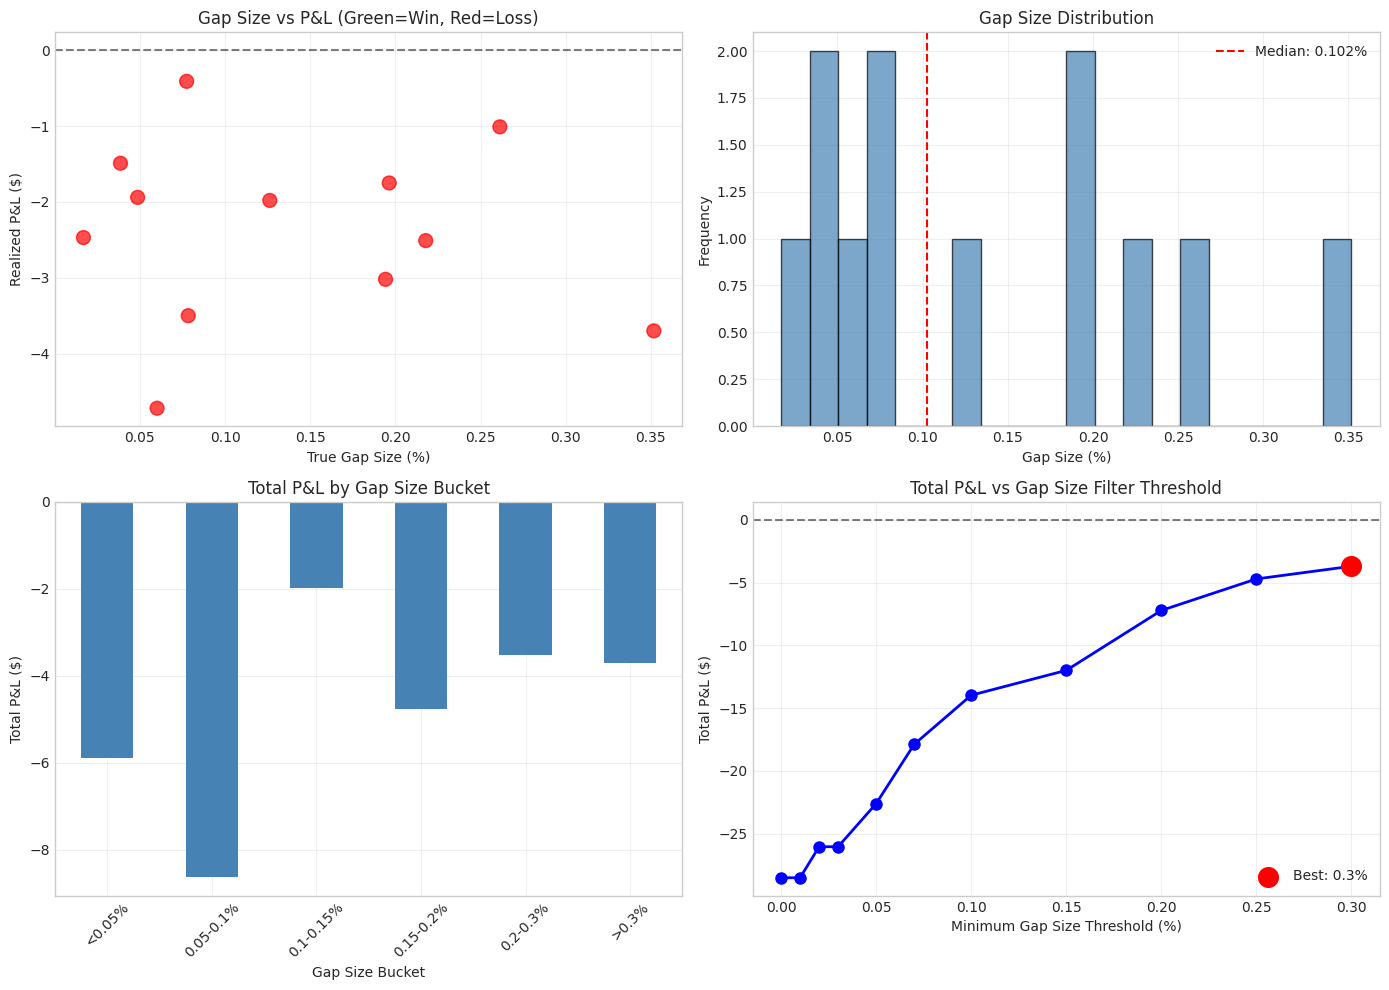

In [22]:
# Cell 3B.5: Visualize Gap Size vs P&L

matched_df = trades_15m_with_gaps[trades_15m_with_gaps['true_gap_size_pct'].notna()].copy()

if len(matched_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Scatter: Gap Size vs P&L
    ax1 = axes[0, 0]
    colors = ['green' if s == 'WIN' else 'red' for s in matched_df['Status']]
    ax1.scatter(matched_df['true_gap_size_pct'], matched_df['Realized P&L'], c=colors, alpha=0.7, s=100)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('True Gap Size (%)')
    ax1.set_ylabel('Realized P&L ($)')
    ax1.set_title('Gap Size vs P&L (Green=Win, Red=Loss)')
    ax1.grid(True, alpha=0.3)
    
    # Gap Size Distribution
    ax2 = axes[0, 1]
    ax2.hist(matched_df['true_gap_size_pct'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    ax2.axvline(x=matched_df['true_gap_size_pct'].median(), color='red', linestyle='--', 
                label=f'Median: {matched_df["true_gap_size_pct"].median():.3f}%')
    ax2.set_xlabel('Gap Size (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Gap Size Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # P&L by Gap Size Bucket
    ax3 = axes[1, 0]
    matched_df['gap_bucket'] = pd.cut(
        matched_df['true_gap_size_pct'], 
        bins=[0, 0.05, 0.10, 0.15, 0.20, 0.30, float('inf')],
        labels=['<0.05%', '0.05-0.1%', '0.1-0.15%', '0.15-0.2%', '0.2-0.3%', '>0.3%']
    )
    bucket_pnl = matched_df.groupby('gap_bucket', observed=True)['Realized P&L'].sum()
    bucket_pnl.plot(kind='bar', ax=ax3, color='steelblue')
    ax3.set_xlabel('Gap Size Bucket')
    ax3.set_ylabel('Total P&L ($)')
    ax3.set_title('Total P&L by Gap Size Bucket')
    ax3.tick_params(axis='x', rotation=45)
    ax3.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax3.grid(True, alpha=0.3)
    
    # Cumulative P&L at Threshold
    ax4 = axes[1, 1]
    if optimization_table is not None:
        thresholds = [float(t.replace('%','')) for t in optimization_table['Threshold (%)']]
        pnls = optimization_table['_total_pnl'].values
        ax4.plot(thresholds, pnls, 'b-o', linewidth=2, markersize=8)
        ax4.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        ax4.set_xlabel('Minimum Gap Size Threshold (%)')
        ax4.set_ylabel('Total P&L ($)')
        ax4.set_title('Total P&L vs Gap Size Filter Threshold')
        ax4.grid(True, alpha=0.3)
        
        # Highlight best point
        best_idx = np.argmax(pnls)
        ax4.scatter([thresholds[best_idx]], [pnls[best_idx]], color='red', s=200, zorder=5, label=f'Best: {thresholds[best_idx]}%')
        ax4.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No matched trades to visualize.")

---
## Section 4: MFE/MAE Calculation

In [23]:
# Cell 4.1: Binance Klines Fetcher for MFE/MAE

async def fetch_klines(symbol, interval, start_time, end_time):
    """
    Fetch historical klines from Binance Futures API.
    """
    url = f"{BINANCE_FUTURES_API}/fapi/v1/klines"
    
    # Ensure timezone aware
    if start_time.tzinfo is None:
        start_time = start_time.replace(tzinfo=timezone.utc)
    if end_time.tzinfo is None:
        end_time = end_time.replace(tzinfo=timezone.utc)
    
    start_ms = int(start_time.timestamp() * 1000)
    end_ms = int(end_time.timestamp() * 1000)
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ms,
        'endTime': end_ms,
        'limit': 1500
    }
    
    async with aiohttp.ClientSession() as session:
        async with session.get(url, params=params) as resp:
            if resp.status != 200:
                return []
            data = await resp.json()
    
    klines = []
    for k in data:
        klines.append({
            'open_time': datetime.fromtimestamp(k[0] / 1000, tz=timezone.utc),
            'open': float(k[1]),
            'high': float(k[2]),
            'low': float(k[3]),
            'close': float(k[4]),
            'volume': float(k[5])
        })
    
    return klines

print("Klines fetcher for MFE/MAE defined.")

Klines fetcher for MFE/MAE defined.


In [24]:
# Cell 4.2: MFE/MAE Calculation Functions

def calculate_mfe_mae(trade, klines):
    """
    Calculate Maximum Favorable Excursion (MFE) and Maximum Adverse Excursion (MAE).
    
    MFE: Maximum profit point during the trade
    MAE: Maximum loss point during the trade
    """
    if not klines:
        return None
    
    entry_price = trade['Entry Price']
    side = trade['Side']
    position_size = trade['Position Size ($)']
    
    if side == 'LONG':
        # For LONG: MFE is highest high, MAE is lowest low
        max_price = max(k['high'] for k in klines)
        min_price = min(k['low'] for k in klines)
        
        mfe_pct = (max_price - entry_price) / entry_price * 100
        mae_pct = (entry_price - min_price) / entry_price * 100
        
        mfe_usd = position_size * (max_price - entry_price) / entry_price
        mae_usd = position_size * (entry_price - min_price) / entry_price
        
    else:  # SHORT
        # For SHORT: MFE is lowest low, MAE is highest high
        max_price = max(k['high'] for k in klines)
        min_price = min(k['low'] for k in klines)
        
        mfe_pct = (entry_price - min_price) / entry_price * 100
        mae_pct = (max_price - entry_price) / entry_price * 100
        
        mfe_usd = position_size * (entry_price - min_price) / entry_price
        mae_usd = position_size * (max_price - entry_price) / entry_price
    
    return {
        'MFE_pct': mfe_pct,
        'MAE_pct': mae_pct,
        'MFE_usd': mfe_usd,
        'MAE_usd': mae_usd,
        'max_price': max_price,
        'min_price': min_price
    }

print("MFE/MAE calculation functions defined.")

MFE/MAE calculation functions defined.


In [25]:
# Cell 4.3: Fetch Klines and Calculate MFE/MAE for All Trades

async def add_mfe_mae_to_trades(df):
    """Fetch klines and add MFE/MAE columns to trades DataFrame."""
    df = df.copy()
    
    mfe_pct_list = []
    mae_pct_list = []
    mfe_usd_list = []
    mae_usd_list = []
    
    total = len(df)
    
    for i, (_, trade) in enumerate(df.iterrows()):
        if pd.isna(trade['Close Time']):
            mfe_pct_list.append(None)
            mae_pct_list.append(None)
            mfe_usd_list.append(None)
            mae_usd_list.append(None)
            continue
        
        # Fetch 1-minute klines during trade period
        open_time = trade['Open Time']
        close_time = trade['Close Time']
        
        if open_time.tzinfo is None:
            open_time = open_time.replace(tzinfo=timezone.utc)
        if close_time.tzinfo is None:
            close_time = close_time.replace(tzinfo=timezone.utc)
        
        klines = await fetch_klines(trade['Market'], '1m', open_time, close_time)
        
        result = calculate_mfe_mae(trade, klines)
        
        if result:
            mfe_pct_list.append(result['MFE_pct'])
            mae_pct_list.append(result['MAE_pct'])
            mfe_usd_list.append(result['MFE_usd'])
            mae_usd_list.append(result['MAE_usd'])
        else:
            mfe_pct_list.append(None)
            mae_pct_list.append(None)
            mfe_usd_list.append(None)
            mae_usd_list.append(None)
        
        # Progress indicator
        if (i + 1) % 10 == 0:
            print(f"  Processed {i + 1}/{total} trades...")
        
        # Rate limiting
        await asyncio.sleep(0.15)
    
    df['MFE_pct'] = mfe_pct_list
    df['MAE_pct'] = mae_pct_list
    df['MFE_usd'] = mfe_usd_list
    df['MAE_usd'] = mae_usd_list
    
    return df

print("Fetching klines and calculating MFE/MAE (this may take a few minutes)...")
trades_15m_mfe = await add_mfe_mae_to_trades(trades_15m_gap)
print(f"\nMFE/MAE calculation complete. Valid records: {trades_15m_mfe['MFE_pct'].notna().sum()}")

Fetching klines and calculating MFE/MAE (this may take a few minutes)...


  Processed 10/48 trades...


  Processed 20/48 trades...


  Processed 30/48 trades...


  Processed 40/48 trades...



MFE/MAE calculation complete. Valid records: 48


In [26]:
# Cell 4.4: MFE/MAE Analysis

def analyze_mfe_mae(df):
    """Analyze MFE/MAE distributions and suggest TP/SL levels."""
    valid_df = df.dropna(subset=['MFE_pct', 'MAE_pct'])
    
    if len(valid_df) == 0:
        return None
    
    analysis = {
        'mfe_stats': {
            'mean': valid_df['MFE_pct'].mean(),
            'median': valid_df['MFE_pct'].median(),
            'std': valid_df['MFE_pct'].std(),
            'percentiles': valid_df['MFE_pct'].quantile([0.25, 0.5, 0.75, 0.9]).to_dict()
        },
        'mae_stats': {
            'mean': valid_df['MAE_pct'].mean(),
            'median': valid_df['MAE_pct'].median(),
            'std': valid_df['MAE_pct'].std(),
            'percentiles': valid_df['MAE_pct'].quantile([0.25, 0.5, 0.75, 0.9]).to_dict()
        }
    }
    
    # MFE/MAE by outcome
    wins = valid_df[valid_df['Status'] == 'WIN']
    losses = valid_df[valid_df['Status'] == 'LOSS']
    
    analysis['wins_mfe_mean'] = wins['MFE_pct'].mean() if len(wins) > 0 else 0
    analysis['wins_mae_mean'] = wins['MAE_pct'].mean() if len(wins) > 0 else 0
    analysis['losses_mfe_mean'] = losses['MFE_pct'].mean() if len(losses) > 0 else 0
    analysis['losses_mae_mean'] = losses['MAE_pct'].mean() if len(losses) > 0 else 0
    
    # Suggested TP/SL levels
    analysis['suggested_tp_pct'] = wins['MFE_pct'].median() * 0.8 if len(wins) > 0 else 0.5
    analysis['suggested_sl_pct'] = valid_df['MAE_pct'].quantile(0.75)
    
    return analysis

mfe_mae_analysis = analyze_mfe_mae(trades_15m_mfe)

print("\n=== MFE/MAE ANALYSIS ===")
if mfe_mae_analysis:
    print(f"\nMFE Statistics:")
    print(f"  Mean:   {mfe_mae_analysis['mfe_stats']['mean']:.2f}%")
    print(f"  Median: {mfe_mae_analysis['mfe_stats']['median']:.2f}%")
    print(f"  Std:    {mfe_mae_analysis['mfe_stats']['std']:.2f}%")
    print(f"  25th:   {mfe_mae_analysis['mfe_stats']['percentiles'][0.25]:.2f}%")
    print(f"  75th:   {mfe_mae_analysis['mfe_stats']['percentiles'][0.75]:.2f}%")
    print(f"  90th:   {mfe_mae_analysis['mfe_stats']['percentiles'][0.9]:.2f}%")
    
    print(f"\nMAE Statistics:")
    print(f"  Mean:   {mfe_mae_analysis['mae_stats']['mean']:.2f}%")
    print(f"  Median: {mfe_mae_analysis['mae_stats']['median']:.2f}%")
    print(f"  Std:    {mfe_mae_analysis['mae_stats']['std']:.2f}%")
    print(f"  25th:   {mfe_mae_analysis['mae_stats']['percentiles'][0.25]:.2f}%")
    print(f"  75th:   {mfe_mae_analysis['mae_stats']['percentiles'][0.75]:.2f}%")
    print(f"  90th:   {mfe_mae_analysis['mae_stats']['percentiles'][0.9]:.2f}%")
    
    print(f"\nMFE/MAE by Outcome:")
    print(f"  Wins  - Avg MFE: {mfe_mae_analysis['wins_mfe_mean']:.2f}%, Avg MAE: {mfe_mae_analysis['wins_mae_mean']:.2f}%")
    print(f"  Losses- Avg MFE: {mfe_mae_analysis['losses_mfe_mean']:.2f}%, Avg MAE: {mfe_mae_analysis['losses_mae_mean']:.2f}%")


=== MFE/MAE ANALYSIS ===

MFE Statistics:
  Mean:   0.36%
  Median: 0.20%
  Std:    0.44%
  25th:   0.06%
  75th:   0.48%
  90th:   0.82%

MAE Statistics:
  Mean:   0.24%
  Median: 0.18%
  Std:    0.17%
  25th:   0.12%
  75th:   0.34%
  90th:   0.46%

MFE/MAE by Outcome:
  Wins  - Avg MFE: 1.03%, Avg MAE: 0.12%
  Losses- Avg MFE: 0.18%, Avg MAE: 0.27%


In [27]:
# Cell 4.5: Suggested TP/SL Levels

print("\n" + "="*50)
print("  SUGGESTED RISK MANAGEMENT LEVELS")
print("="*50)

if mfe_mae_analysis:
    print(f"\n  TAKE PROFIT: {mfe_mae_analysis['suggested_tp_pct']:.2f}%")
    print(f"    Based on: 80% of median winning trade MFE")
    print(f"    Rationale: Capture most of favorable move before reversal")
    
    print(f"\n  STOP LOSS: {mfe_mae_analysis['suggested_sl_pct']:.2f}%")
    print(f"    Based on: 75th percentile MAE")
    print(f"    Rationale: Allow normal volatility, cut outlier losses")
    
    # Calculate expected outcomes with TP/SL
    tp = mfe_mae_analysis['suggested_tp_pct']
    sl = mfe_mae_analysis['suggested_sl_pct']
    
    print(f"\n  Risk/Reward Ratio: 1:{tp/sl:.2f}")
else:
    print("\n  Insufficient data for TP/SL recommendations.")


  SUGGESTED RISK MANAGEMENT LEVELS

  TAKE PROFIT: 0.67%
    Based on: 80% of median winning trade MFE
    Rationale: Capture most of favorable move before reversal

  STOP LOSS: 0.34%
    Based on: 75th percentile MAE
    Rationale: Allow normal volatility, cut outlier losses

  Risk/Reward Ratio: 1:1.98


---
## Section 5: Visualizations

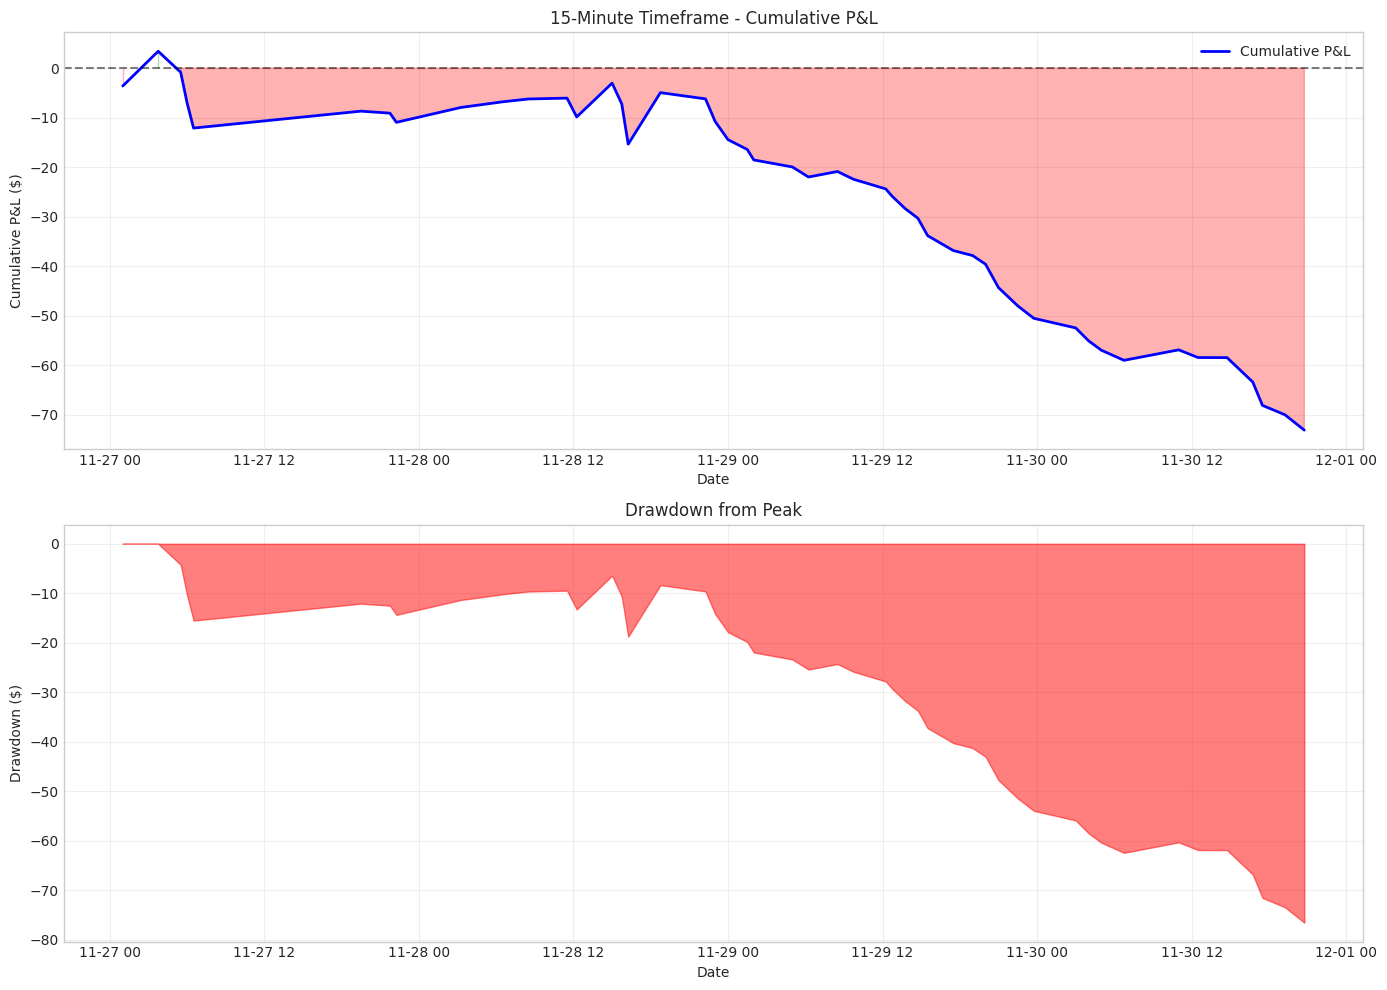

In [28]:
# Cell 5.1: Equity Curve

def plot_equity_curve(df, title="Equity Curve"):
    """Plot cumulative P&L over time with drawdown."""
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Equity curve
    ax1 = axes[0]
    ax1.plot(df['Close Time'], df['Cumulative P&L'], 'b-', linewidth=2, label='Cumulative P&L')
    ax1.fill_between(df['Close Time'], 0, df['Cumulative P&L'], 
                     where=df['Cumulative P&L'] >= 0, alpha=0.3, color='green')
    ax1.fill_between(df['Close Time'], 0, df['Cumulative P&L'], 
                     where=df['Cumulative P&L'] < 0, alpha=0.3, color='red')
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Cumulative P&L ($)')
    ax1.set_title(f'{title} - Cumulative P&L')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Drawdown
    ax2 = axes[1]
    cumulative = df['Cumulative P&L'].values
    peak = np.maximum.accumulate(cumulative)
    drawdown = peak - cumulative
    ax2.fill_between(df['Close Time'], 0, -drawdown, color='red', alpha=0.5)
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Drawdown ($)')
    ax2.set_title('Drawdown from Peak')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot 15m equity curve
fig_equity = plot_equity_curve(trades_15m_mfe, "15-Minute Timeframe")
plt.show()

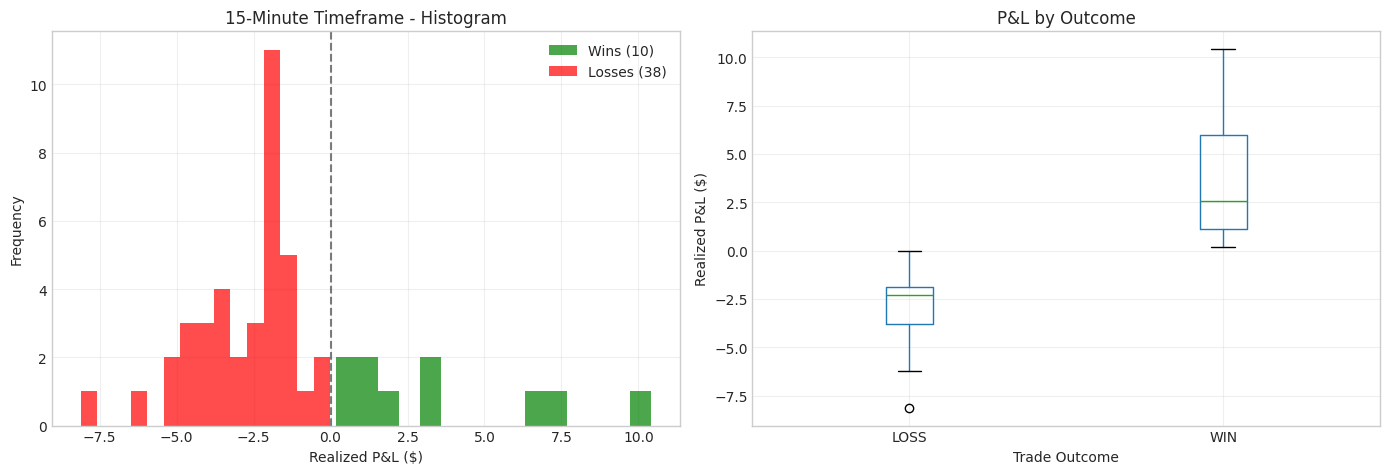

In [29]:
# Cell 5.2: P&L Distribution

def plot_pnl_distribution(df, title="P&L Distribution"):
    """Plot P&L distribution histogram and boxplot."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    ax1 = axes[0]
    wins = df[df['Status'] == 'WIN']['Realized P&L']
    losses = df[df['Status'] == 'LOSS']['Realized P&L']
    
    ax1.hist(wins, bins=15, alpha=0.7, label=f'Wins ({len(wins)})', color='green')
    ax1.hist(losses, bins=15, alpha=0.7, label=f'Losses ({len(losses)})', color='red')
    ax1.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Realized P&L ($)')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'{title} - Histogram')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Box plot
    ax2 = axes[1]
    df.boxplot(column='Realized P&L', by='Status', ax=ax2)
    ax2.set_xlabel('Trade Outcome')
    ax2.set_ylabel('Realized P&L ($)')
    ax2.set_title('P&L by Outcome')
    plt.suptitle('')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig_pnl = plot_pnl_distribution(trades_15m_mfe, "15-Minute Timeframe")
plt.show()

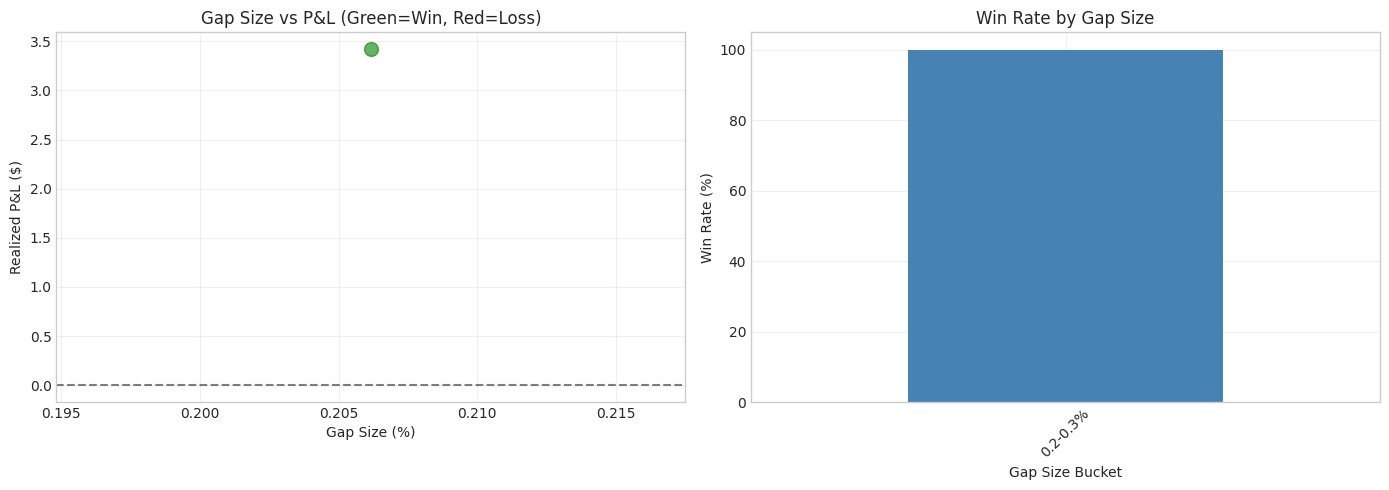

In [30]:
# Cell 5.3: Gap Size Analysis Plots

def plot_gap_vs_outcome(df):
    """Scatter plot of gap size vs trade outcome."""
    df_valid = df[df['Gap_Size_Pct'] > 0].copy()
    
    if len(df_valid) == 0:
        print("No valid gap data for plotting.")
        return None
    
    # Create buckets
    df_valid['Gap_Size_Bucket'] = pd.cut(
        df_valid['Gap_Size_Pct'], 
        bins=[0, 0.1, 0.2, 0.3, 0.5, float('inf')],
        labels=['<0.1%', '0.1-0.2%', '0.2-0.3%', '0.3-0.5%', '>0.5%']
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Scatter: Gap Size vs P&L
    ax1 = axes[0]
    colors = ['green' if s == 'WIN' else 'red' for s in df_valid['Status']]
    ax1.scatter(df_valid['Gap_Size_Pct'], df_valid['Realized P&L'], c=colors, alpha=0.6, s=100)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Gap Size (%)')
    ax1.set_ylabel('Realized P&L ($)')
    ax1.set_title('Gap Size vs P&L (Green=Win, Red=Loss)')
    ax1.grid(True, alpha=0.3)
    
    # Win Rate by Gap Size Bucket
    ax2 = axes[1]
    bucket_data = df_valid.groupby('Gap_Size_Bucket', observed=True).apply(
        lambda x: (x['Status'] == 'WIN').sum() / len(x) * 100 if len(x) > 0 else 0
    )
    bucket_data.plot(kind='bar', ax=ax2, color='steelblue')
    ax2.set_xlabel('Gap Size Bucket')
    ax2.set_ylabel('Win Rate (%)')
    ax2.set_title('Win Rate by Gap Size')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig_gap = plot_gap_vs_outcome(trades_15m_mfe)
if fig_gap:
    plt.show()

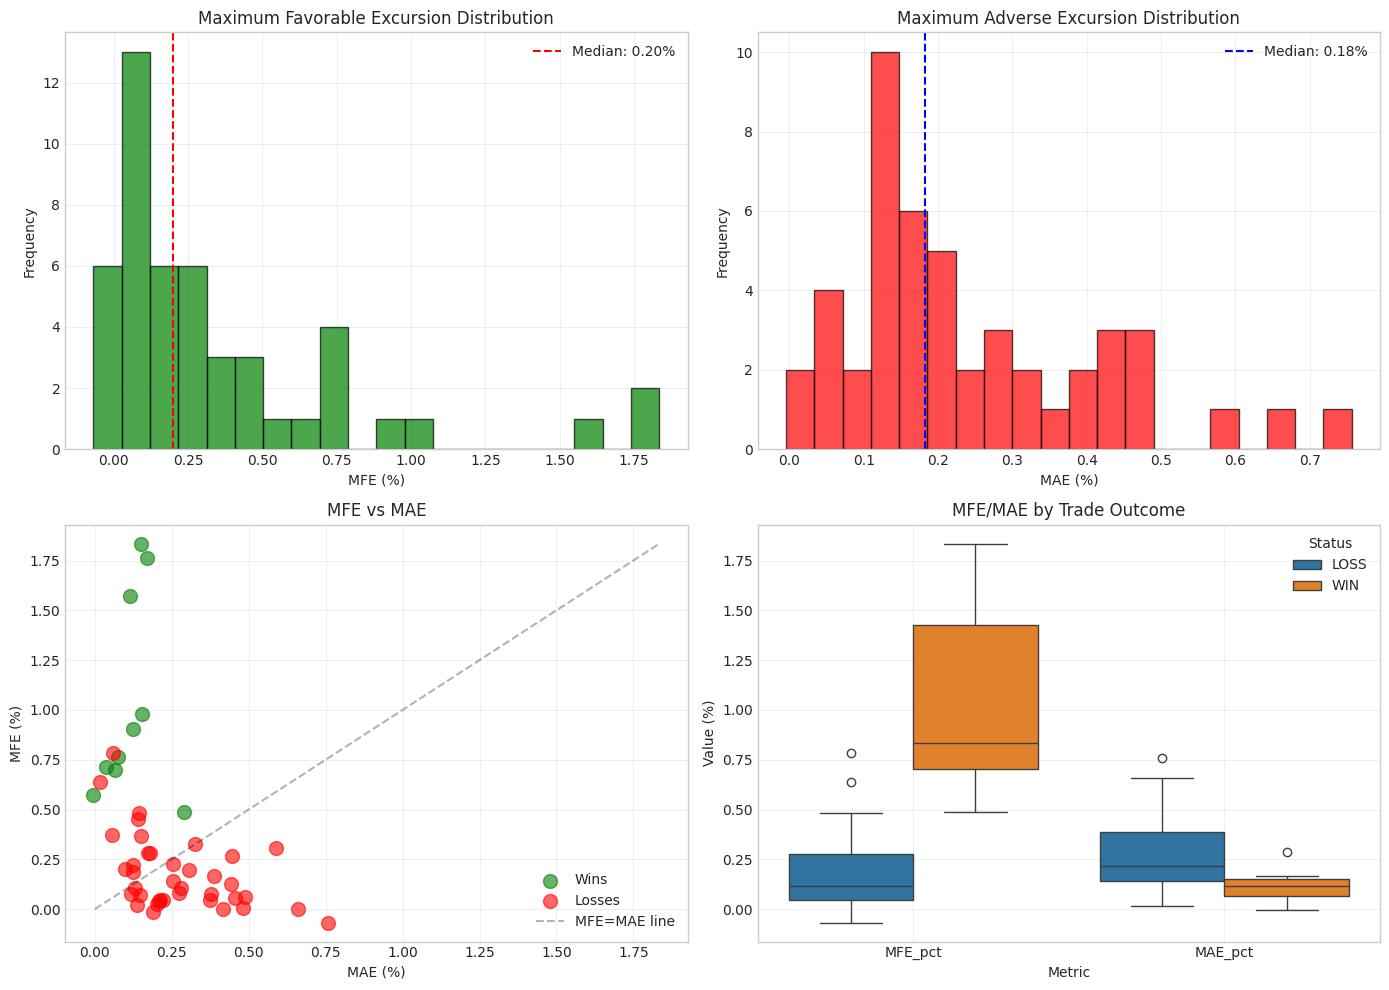

In [31]:
# Cell 5.4: MFE/MAE Distribution Plots

def plot_mfe_mae_distributions(df):
    """Plot MFE and MAE distributions."""
    valid_df = df.dropna(subset=['MFE_pct', 'MAE_pct'])
    
    if len(valid_df) == 0:
        print("No valid MFE/MAE data for plotting.")
        return None
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # MFE Distribution
    ax1 = axes[0, 0]
    ax1.hist(valid_df['MFE_pct'], bins=20, color='green', alpha=0.7, edgecolor='black')
    ax1.axvline(x=valid_df['MFE_pct'].median(), color='red', linestyle='--', 
                label=f'Median: {valid_df["MFE_pct"].median():.2f}%')
    ax1.set_xlabel('MFE (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Maximum Favorable Excursion Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # MAE Distribution
    ax2 = axes[0, 1]
    ax2.hist(valid_df['MAE_pct'], bins=20, color='red', alpha=0.7, edgecolor='black')
    ax2.axvline(x=valid_df['MAE_pct'].median(), color='blue', linestyle='--', 
                label=f'Median: {valid_df["MAE_pct"].median():.2f}%')
    ax2.set_xlabel('MAE (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Maximum Adverse Excursion Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # MFE vs MAE Scatter
    ax3 = axes[1, 0]
    wins = valid_df[valid_df['Status'] == 'WIN']
    losses = valid_df[valid_df['Status'] == 'LOSS']
    ax3.scatter(wins['MAE_pct'], wins['MFE_pct'], c='green', alpha=0.6, s=100, label='Wins')
    ax3.scatter(losses['MAE_pct'], losses['MFE_pct'], c='red', alpha=0.6, s=100, label='Losses')
    
    max_val = max(valid_df['MAE_pct'].max(), valid_df['MFE_pct'].max())
    ax3.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, label='MFE=MAE line')
    ax3.set_xlabel('MAE (%)')
    ax3.set_ylabel('MFE (%)')
    ax3.set_title('MFE vs MAE')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # MFE/MAE by Outcome (Box plots)
    ax4 = axes[1, 1]
    mfe_mae_melted = valid_df.melt(
        id_vars=['Status'], 
        value_vars=['MFE_pct', 'MAE_pct'],
        var_name='Metric', 
        value_name='Value'
    )
    sns.boxplot(data=mfe_mae_melted, x='Metric', y='Value', hue='Status', ax=ax4)
    ax4.set_xlabel('Metric')
    ax4.set_ylabel('Value (%)')
    ax4.set_title('MFE/MAE by Trade Outcome')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

fig_mfe_mae = plot_mfe_mae_distributions(trades_15m_mfe)
if fig_mfe_mae:
    plt.show()

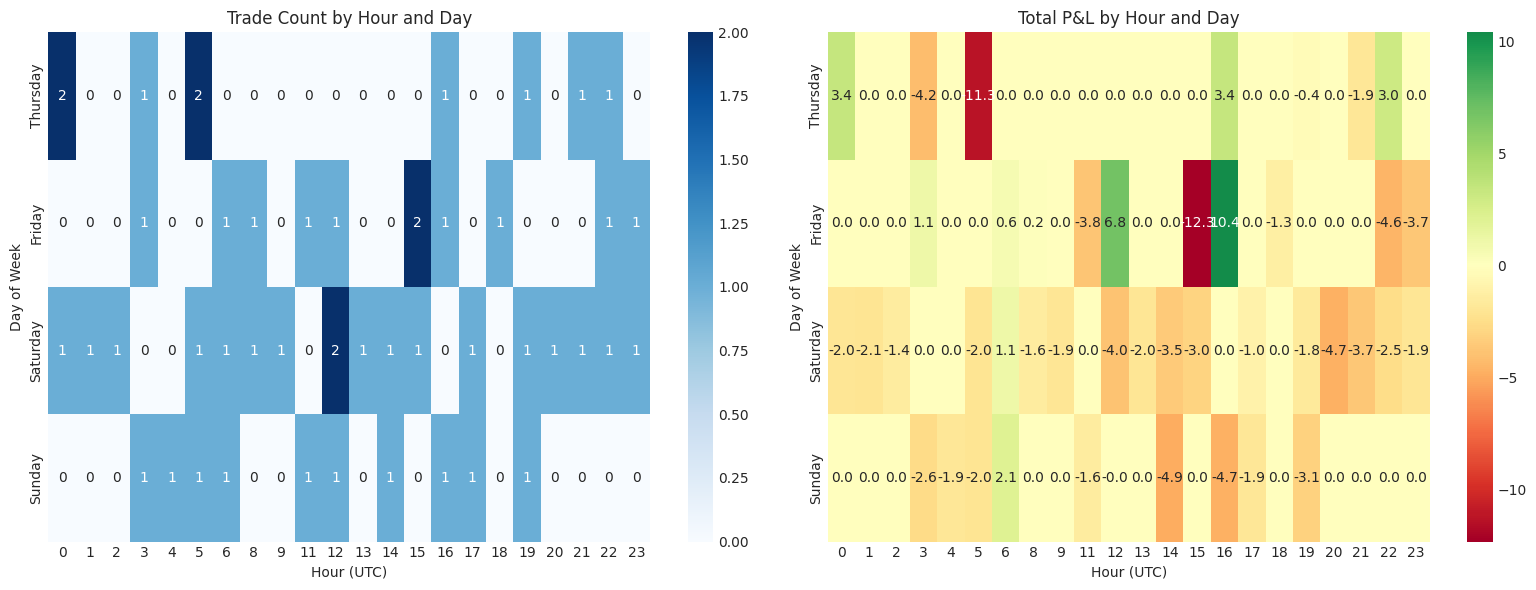

In [32]:
# Cell 5.5: Trade Heatmap by Hour/Day

def plot_trade_heatmap(df):
    """Create heatmap of trade performance by hour and day of week."""
    df = df.copy()
    df['Hour'] = df['Open Time'].dt.hour
    df['DayOfWeek'] = df['Open Time'].dt.day_name()
    
    # Pivot for heatmap
    pivot_count = df.pivot_table(
        values='Realized P&L', 
        index='DayOfWeek', 
        columns='Hour', 
        aggfunc='count', 
        fill_value=0
    )
    
    pivot_pnl = df.pivot_table(
        values='Realized P&L', 
        index='DayOfWeek', 
        columns='Hour', 
        aggfunc='sum', 
        fill_value=0
    )
    
    # Reorder days
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    pivot_count = pivot_count.reindex([d for d in day_order if d in pivot_count.index])
    pivot_pnl = pivot_pnl.reindex([d for d in day_order if d in pivot_pnl.index])
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Trade Count Heatmap
    sns.heatmap(pivot_count, annot=True, fmt='g', cmap='Blues', ax=axes[0])
    axes[0].set_title('Trade Count by Hour and Day')
    axes[0].set_xlabel('Hour (UTC)')
    axes[0].set_ylabel('Day of Week')
    
    # P&L Heatmap
    sns.heatmap(pivot_pnl, annot=True, fmt='.1f', cmap='RdYlGn', center=0, ax=axes[1])
    axes[1].set_title('Total P&L by Hour and Day')
    axes[1].set_xlabel('Hour (UTC)')
    axes[1].set_ylabel('Day of Week')
    
    plt.tight_layout()
    return fig

fig_heatmap = plot_trade_heatmap(trades_15m_mfe)
plt.show()

---
## Section 7: Backtest Recommendations

**Question**: What would have happened if we had implemented the recommended TP/SL?

| Recommendation | Value | Source |
|----------------|-------|--------|
| Take Profit | 0.67% | 80% of median winning MFE |
| Stop Loss | 0.34% | 75th percentile MAE |

In [33]:
# Cell 7.1: Backtest TP/SL Implementation

# Parameters from recommendations
TP_PCT = 0.67  # Take Profit %
SL_PCT = 0.34  # Stop Loss %
POSITION_SIZE = 1000
FEE = 0.60

print("=" * 70)
print("BACKTEST: WHAT IF WE HAD IMPLEMENTED THE RECOMMENDATIONS?")
print("=" * 70)
print(f"\nRecommendations being tested:")
print(f"  Take Profit: {TP_PCT}%  → +${POSITION_SIZE * TP_PCT / 100 - FEE:.2f} per win")
print(f"  Stop Loss:   {SL_PCT}%  → -${POSITION_SIZE * SL_PCT / 100 + FEE:.2f} per loss")

# Use the enhanced trades data with MFE/MAE
df_backtest = trades_15m_mfe.copy()

# Simulate TP/SL outcomes
simulated_results = []

for idx, trade in df_backtest.iterrows():
    mfe = trade['MFE_pct']
    mae = trade['MAE_pct']
    actual_pnl = trade['Realized P&L']
    actual_status = trade['Status']
    
    if pd.isna(mfe) or pd.isna(mae):
        sim_pnl = actual_pnl
        outcome = 'NO_DATA'
    elif mfe >= TP_PCT:
        # Would have hit Take Profit
        sim_pnl = POSITION_SIZE * (TP_PCT / 100) - FEE
        outcome = 'TP_HIT'
    elif mae >= SL_PCT:
        # Would have hit Stop Loss
        sim_pnl = -POSITION_SIZE * (SL_PCT / 100) - FEE
        outcome = 'SL_HIT'
    else:
        # Neither hit, use actual result
        sim_pnl = actual_pnl
        outcome = 'NEITHER'
    
    simulated_results.append({
        'Open Time': trade['Open Time'],
        'Side': trade['Side'],
        'Entry Price': trade['Entry Price'],
        'Actual_PnL': actual_pnl,
        'Actual_Status': actual_status,
        'MFE_pct': mfe,
        'MAE_pct': mae,
        'Simulated_PnL': sim_pnl,
        'Sim_Outcome': outcome,
        'Sim_Status': 'WIN' if sim_pnl > 0 else 'LOSS'
    })

sim_df = pd.DataFrame(simulated_results)

# Calculate metrics
baseline_pnl = df_backtest['Realized P&L'].sum()
baseline_wins = (df_backtest['Status'] == 'WIN').sum()
sim_total_pnl = sim_df['Simulated_PnL'].sum()
sim_wins = (sim_df['Simulated_PnL'] > 0).sum()

print("\n" + "=" * 70)

BACKTEST: WHAT IF WE HAD IMPLEMENTED THE RECOMMENDATIONS?

Recommendations being tested:
  Take Profit: 0.67%  → +$6.10 per win
  Stop Loss:   0.34%  → -$4.00 per loss



In [34]:
# Cell 7.2: Backtest Results Comparison

# Outcome breakdown
tp_hits = (sim_df['Sim_Outcome'] == 'TP_HIT').sum()
sl_hits = (sim_df['Sim_Outcome'] == 'SL_HIT').sum()
neither = (sim_df['Sim_Outcome'] == 'NEITHER').sum()

# Calculate improvements
pnl_improvement = sim_total_pnl - baseline_pnl
win_rate_baseline = baseline_wins / len(df_backtest) * 100
win_rate_sim = sim_wins / len(sim_df) * 100
win_rate_improvement = win_rate_sim - win_rate_baseline

# Drawdown calculation
sim_cumulative = sim_df['Simulated_PnL'].cumsum()
sim_peak = sim_cumulative.cummax()
sim_dd = (sim_peak - sim_cumulative).max()
baseline_dd = metrics_15m['max_drawdown']

print("=" * 70)
print("                     BACKTEST RESULTS COMPARISON")
print("=" * 70)
print()

# Create comparison DataFrame
comparison_data = {
    'Metric': ['Total Trades', 'Wins', 'Losses', 'Win Rate', 'Total P&L', 'Max Drawdown'],
    'Baseline': [
        f"{len(df_backtest)}",
        f"{baseline_wins}",
        f"{len(df_backtest) - baseline_wins}",
        f"{win_rate_baseline:.1f}%",
        f"${baseline_pnl:.2f}",
        f"${baseline_dd:.2f}"
    ],
    'With TP/SL': [
        f"{len(sim_df)}",
        f"{sim_wins}",
        f"{len(sim_df) - sim_wins}",
        f"{win_rate_sim:.1f}%",
        f"${sim_total_pnl:.2f}",
        f"${sim_dd:.2f}"
    ],
    'Change': [
        "-",
        f"{'+' if sim_wins > baseline_wins else ''}{sim_wins - baseline_wins}",
        f"{'+' if (len(sim_df) - sim_wins) > (len(df_backtest) - baseline_wins) else ''}{(len(sim_df) - sim_wins) - (len(df_backtest) - baseline_wins)}",
        f"{'+' if win_rate_improvement >= 0 else ''}{win_rate_improvement:.1f}%",
        f"{'+' if pnl_improvement >= 0 else ''}${pnl_improvement:.2f}",
        f"-${baseline_dd - sim_dd:.2f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

print()
print("Outcome Breakdown:")
print(f"  TP Hit:   {tp_hits} trades (MFE >= {TP_PCT}%)")
print(f"  SL Hit:   {sl_hits} trades (MAE >= {SL_PCT}% before TP)")
print(f"  Neither:  {neither} trades (actual result used)")
print()
print("=" * 70)

if pnl_improvement > 0:
    print(f"  ✓ TP/SL WOULD HAVE IMPROVED P&L by ${pnl_improvement:.2f}")
else:
    print(f"  ✗ TP/SL WOULD HAVE WORSENED P&L by ${abs(pnl_improvement):.2f}")
print("=" * 70)

                     BACKTEST RESULTS COMPARISON



,Metric,Baseline,With TP/SL,Change
0,Total Trades,48,48,-
1,Wins,10,11,+1
2,Losses,38,37,-1
3,Win Rate,20.8%,22.9%,+2.1%
4,Total P&L,$-73.13,$-42.68,+$30.45
5,Max Drawdown,$76.57,$57.59,-$18.98



Outcome Breakdown:
  TP Hit:   9 trades (MFE >= 0.67%)
  SL Hit:   12 trades (MAE >= 0.34% before TP)
  Neither:  27 trades (actual result used)

  ✓ TP/SL WOULD HAVE IMPROVED P&L by $30.45


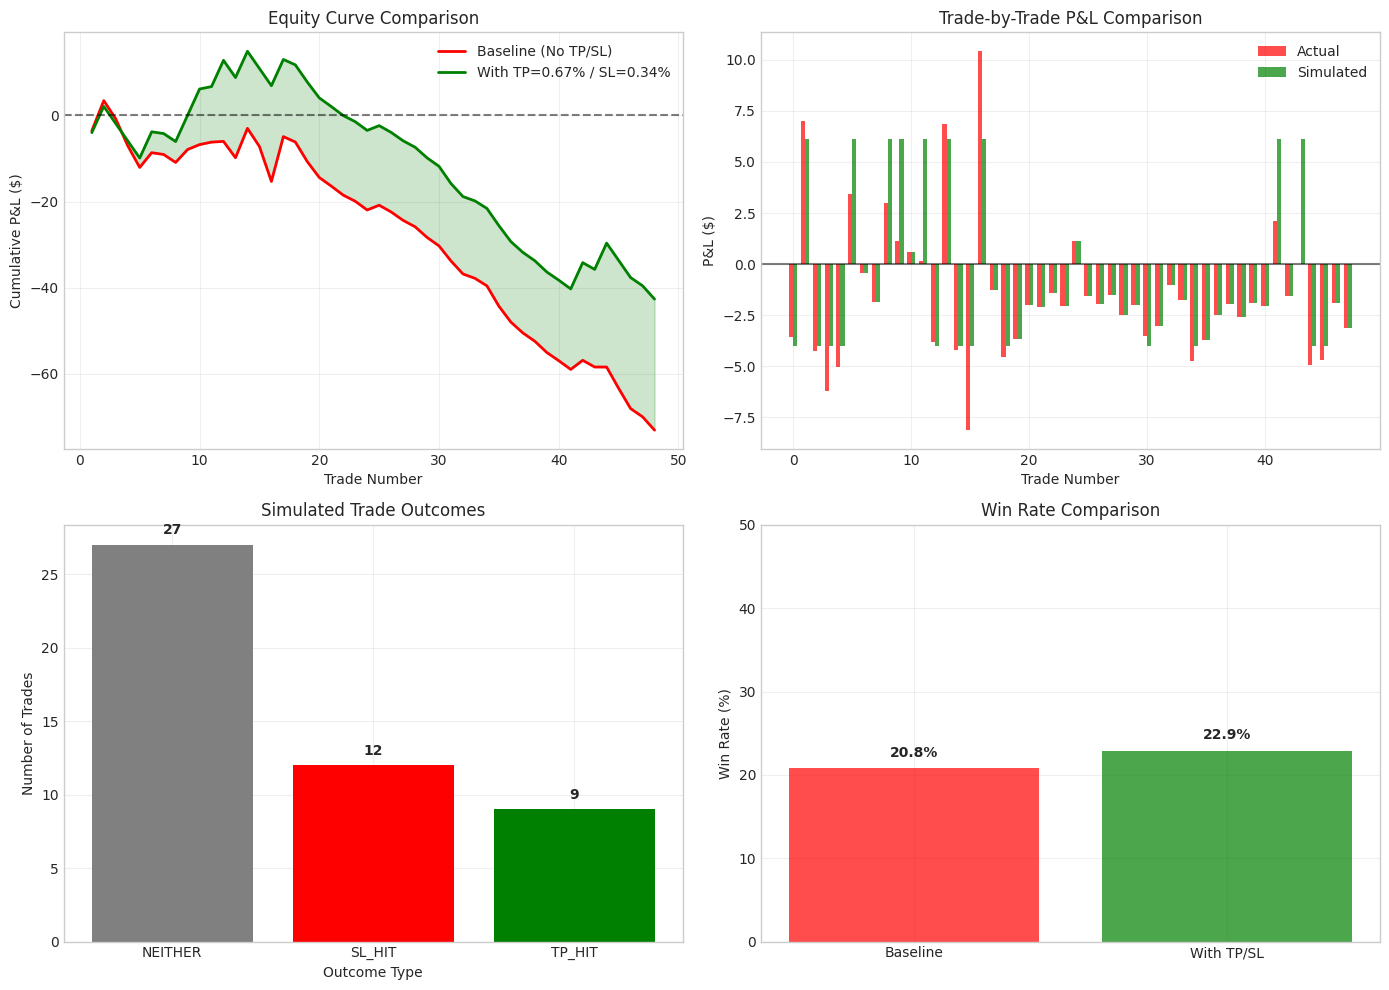

In [35]:
# Cell 7.3: Equity Curve Comparison Visualization

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Equity Curves Comparison
ax1 = axes[0, 0]
baseline_equity = df_backtest['Cumulative P&L'].values
sim_equity = sim_df['Simulated_PnL'].cumsum().values
trade_nums = range(1, len(baseline_equity) + 1)

ax1.plot(trade_nums, baseline_equity, 'r-', linewidth=2, label='Baseline (No TP/SL)')
ax1.plot(trade_nums, sim_equity, 'g-', linewidth=2, label=f'With TP={TP_PCT}% / SL={SL_PCT}%')
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax1.fill_between(trade_nums, baseline_equity, sim_equity, alpha=0.2, color='green', 
                  where=[s > b for s, b in zip(sim_equity, baseline_equity)])
ax1.set_xlabel('Trade Number')
ax1.set_ylabel('Cumulative P&L ($)')
ax1.set_title('Equity Curve Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Trade-by-Trade P&L Comparison
ax2 = axes[0, 1]
x = range(len(sim_df))
width = 0.35
ax2.bar([i - width/2 for i in x], sim_df['Actual_PnL'], width, label='Actual', alpha=0.7, color='red')
ax2.bar([i + width/2 for i in x], sim_df['Simulated_PnL'], width, label='Simulated', alpha=0.7, color='green')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax2.set_xlabel('Trade Number')
ax2.set_ylabel('P&L ($)')
ax2.set_title('Trade-by-Trade P&L Comparison')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Outcome Distribution
ax3 = axes[1, 0]
outcome_counts = sim_df['Sim_Outcome'].value_counts()
colors = {'TP_HIT': 'green', 'SL_HIT': 'red', 'NEITHER': 'gray', 'NO_DATA': 'lightgray'}
bars = ax3.bar(outcome_counts.index, outcome_counts.values, 
               color=[colors.get(x, 'blue') for x in outcome_counts.index])
ax3.set_xlabel('Outcome Type')
ax3.set_ylabel('Number of Trades')
ax3.set_title('Simulated Trade Outcomes')
ax3.grid(True, alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, outcome_counts.values):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             str(count), ha='center', va='bottom', fontweight='bold')

# Plot 4: Win Rate Comparison
ax4 = axes[1, 1]
categories = ['Baseline', 'With TP/SL']
win_rates = [win_rate_baseline, win_rate_sim]
colors = ['red', 'green']
bars = ax4.bar(categories, win_rates, color=colors, alpha=0.7)
ax4.set_ylabel('Win Rate (%)')
ax4.set_title('Win Rate Comparison')
ax4.set_ylim(0, 50)
ax4.grid(True, alpha=0.3)

# Add value labels
for bar, rate in zip(bars, win_rates):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [36]:
# Cell 7.4: Detailed Trade Outcome Changes

print("=" * 70)
print("                    DETAILED TRADE OUTCOME CHANGES")
print("=" * 70)

# Trades where TP hit (and what actual outcome was)
tp_hit_trades = sim_df[sim_df['Sim_Outcome'] == 'TP_HIT'][['Open Time', 'Side', 'Actual_Status', 'Actual_PnL', 'MFE_pct', 'Simulated_PnL']]
print(f"\n=== TP HIT TRADES ({len(tp_hit_trades)}) ===")
print(f"These trades reached MFE >= {TP_PCT}% and would have closed at TP for +${POSITION_SIZE * TP_PCT / 100 - FEE:.2f}")
display(tp_hit_trades)

# P&L impact from TP hits
actual_pnl_tp_trades = sim_df[sim_df['Sim_Outcome'] == 'TP_HIT']['Actual_PnL'].sum()
sim_pnl_tp_trades = sim_df[sim_df['Sim_Outcome'] == 'TP_HIT']['Simulated_PnL'].sum()
print(f"\nTP Trades Impact: Actual ${actual_pnl_tp_trades:.2f} → Simulated ${sim_pnl_tp_trades:.2f} (Change: ${sim_pnl_tp_trades - actual_pnl_tp_trades:.2f})")

# Trades where SL hit
sl_hit_trades = sim_df[sim_df['Sim_Outcome'] == 'SL_HIT'][['Open Time', 'Side', 'Actual_Status', 'Actual_PnL', 'MAE_pct', 'Simulated_PnL']]
print(f"\n=== SL HIT TRADES ({len(sl_hit_trades)}) ===")
print(f"These trades reached MAE >= {SL_PCT}% before TP and would have closed at SL for -${POSITION_SIZE * SL_PCT / 100 + FEE:.2f}")
display(sl_hit_trades)

# P&L impact from SL hits
actual_pnl_sl_trades = sim_df[sim_df['Sim_Outcome'] == 'SL_HIT']['Actual_PnL'].sum()
sim_pnl_sl_trades = sim_df[sim_df['Sim_Outcome'] == 'SL_HIT']['Simulated_PnL'].sum()
print(f"\nSL Trades Impact: Actual ${actual_pnl_sl_trades:.2f} → Simulated ${sim_pnl_sl_trades:.2f} (Change: ${sim_pnl_sl_trades - actual_pnl_sl_trades:.2f})")

print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
print(f"  TP Hit Impact:     +${sim_pnl_tp_trades - actual_pnl_tp_trades:.2f}")
print(f"  SL Hit Impact:     +${sim_pnl_sl_trades - actual_pnl_sl_trades:.2f}")
print(f"  Total Improvement: +${pnl_improvement:.2f}")
print("=" * 70)

                    DETAILED TRADE OUTCOME CHANGES

=== TP HIT TRADES (9) ===
These trades reached MFE >= 0.67% and would have closed at TP for +$6.10


,Open Time,Side,Actual_Status,Actual_PnL,MFE_pct,Simulated_PnL
1,2025-11-27 00:59:59+00:00,LONG,WIN,7.02,1.574094,6.1
5,2025-11-27 16:30:01+00:00,LONG,WIN,3.42,0.715099,6.1
8,2025-11-27 22:15:01+00:00,SHORT,WIN,3.00,0.902150,6.1
9,2025-11-28 03:15:01+00:00,LONG,WIN,1.15,0.699371,6.1
11,2025-11-28 08:30:01+00:00,LONG,WIN,0.17,0.981607,6.1
13,2025-11-28 12:15:01+00:00,LONG,WIN,6.83,1.762587,6.1
16,2025-11-28 16:15:01+00:00,SHORT,WIN,10.41,1.834071,6.1
41,2025-11-30 06:45:01+00:00,LONG,WIN,2.12,0.766144,6.1
43,2025-11-30 12:30:01+00:00,LONG,LOSS,-0.01,0.784819,6.1



TP Trades Impact: Actual $34.11 → Simulated $54.90 (Change: $20.79)

=== SL HIT TRADES (12) ===
These trades reached MAE >= 0.34% before TP and would have closed at SL for -$4.00


,Open Time,Side,Actual_Status,Actual_PnL,MAE_pct,Simulated_PnL
0,2025-11-27 00:29:59+00:00,SHORT,LOSS,-3.58,0.416271,-4.0
2,2025-11-27 03:44:59+00:00,SHORT,LOSS,-4.24,0.443611,-4.0
3,2025-11-27 05:29:59+00:00,LONG,LOSS,-6.23,0.659943,-4.0
4,2025-11-27 05:59:59+00:00,SHORT,LOSS,-5.05,0.480579,-4.0
12,2025-11-28 11:30:01+00:00,SHORT,LOSS,-3.80,0.377284,-4.0
14,2025-11-28 15:00:01+00:00,SHORT,LOSS,-4.21,0.587297,-4.0
15,2025-11-28 15:45:01+00:00,LONG,LOSS,-8.12,0.756491,-4.0
18,2025-11-28 22:15:01+00:00,SHORT,LOSS,-4.56,0.373259,-4.0
30,2025-11-29 14:45:09+00:00,SHORT,LOSS,-3.50,0.487164,-4.0
34,2025-11-29 20:00:06+00:00,SHORT,LOSS,-4.72,0.446454,-4.0



SL Trades Impact: Actual $-57.66 → Simulated $-48.00 (Change: $9.66)

SUMMARY
  TP Hit Impact:     +$20.79
  SL Hit Impact:     +$9.66
  Total Improvement: +$30.45


---
## Section 6: Recommendations Summary

In [37]:
# Cell 6.1: Generate Comprehensive Recommendations

def generate_recommendations(metrics, gap_analysis, mfe_mae_analysis, fee_analysis, optimal_pct):
    """Generate actionable recommendations based on all analyses."""
    recommendations = []
    
    # Win rate analysis
    if metrics['win_rate'] < 30:
        recommendations.append({
            'category': 'STRATEGY',
            'priority': 'HIGH',
            'recommendation': 'Very low win rate detected. The strategy is experiencing significant whipsaw in ranging markets.',
            'action': 'Consider adding filters to reduce trade frequency and improve signal quality.',
            'metric': f"Current Win Rate: {metrics['win_rate']:.1f}%"
        })
    
    # Fee impact
    if fee_analysis['trades_turned_loss_by_fees'] > 0:
        recommendations.append({
            'category': 'EXECUTION',
            'priority': 'MEDIUM',
            'recommendation': f"{fee_analysis['trades_turned_loss_by_fees']} trades were profitable before fees but became losses after fees.",
            'action': 'Consider reducing trade frequency or finding lower-fee execution venues.',
            'metric': f"Total Fee Drag: ${fee_analysis['fee_drag']:.2f}"
        })
    
    # Gap size filter
    if optimal_pct is not None and len(optimal_pct) > 0:
        best_row = optimal_pct.loc[optimal_pct['win_rate'].idxmax()]
        if best_row['win_rate'] > metrics['win_rate']:
            recommendations.append({
                'category': 'FILTERS',
                'priority': 'HIGH',
                'recommendation': f"Implementing a minimum gap size filter could improve performance.",
                'action': f"Filter trades with gap size < {best_row['threshold']}%",
                'metric': f"Filtered Win Rate: {best_row['win_rate']:.1f}% (vs {metrics['win_rate']:.1f}% current), {best_row['trade_count']} trades"
            })
    
    # MFE/MAE based
    if mfe_mae_analysis:
        if mfe_mae_analysis['suggested_tp_pct'] > 0:
            recommendations.append({
                'category': 'RISK MANAGEMENT',
                'priority': 'MEDIUM',
                'recommendation': 'Trades show favorable excursions that could be captured with take profit.',
                'action': f"Implement Take Profit at {mfe_mae_analysis['suggested_tp_pct']:.2f}%",
                'metric': f"Avg Winning Trade MFE: {mfe_mae_analysis['wins_mfe_mean']:.2f}%"
            })
        
        if mfe_mae_analysis['suggested_sl_pct'] > 0:
            recommendations.append({
                'category': 'RISK MANAGEMENT',
                'priority': 'HIGH',
                'recommendation': 'Trades experience significant adverse excursions before closing.',
                'action': f"Implement Stop Loss at {mfe_mae_analysis['suggested_sl_pct']:.2f}%",
                'metric': f"75th Percentile MAE: {mfe_mae_analysis['suggested_sl_pct']:.2f}%"
            })
    
    # Consecutive losses
    if streaks_15m['max_loss_streak'] > 10:
        recommendations.append({
            'category': 'RISK MANAGEMENT',
            'priority': 'HIGH',
            'recommendation': f"Strategy experienced {streaks_15m['max_loss_streak']} consecutive losses.",
            'action': 'Consider implementing a circuit breaker after N consecutive losses.',
            'metric': f"Max Loss Streak: {streaks_15m['max_loss_streak']}"
        })
    
    return recommendations

recommendations = generate_recommendations(
    metrics_15m, gap_analysis, mfe_mae_analysis, fee_analysis_15m, optimal_pct
)

In [38]:
# Cell 6.2: Display Recommendations

print("\n" + "="*70)
print("                    OPTIMIZATION RECOMMENDATIONS")
print("="*70)

for i, rec in enumerate(recommendations, 1):
    priority_color = {
        'HIGH': '!!!',
        'MEDIUM': '!!',
        'LOW': '!'
    }.get(rec['priority'], '')
    
    print(f"\n{i}. [{rec['category']}] {priority_color} Priority: {rec['priority']}")
    print(f"   {rec['recommendation']}")
    print(f"   Action: {rec['action']}")
    print(f"   Metric: {rec['metric']}")

print("\n" + "="*70)


                    OPTIMIZATION RECOMMENDATIONS

1. [STRATEGY] !!! Priority: HIGH
   Very low win rate detected. The strategy is experiencing significant whipsaw in ranging markets.
   Action: Consider adding filters to reduce trade frequency and improve signal quality.
   Metric: Current Win Rate: 20.8%

2. [EXECUTION] !! Priority: MEDIUM
   2 trades were profitable before fees but became losses after fees.
   Action: Consider reducing trade frequency or finding lower-fee execution venues.
   Metric: Total Fee Drag: $28.80

3. [FILTERS] !!! Priority: HIGH
   Implementing a minimum gap size filter could improve performance.
   Action: Filter trades with gap size < 0.05%
   Metric: Filtered Win Rate: 100.0% (vs 20.8% current), 1.0 trades

4. [RISK MANAGEMENT] !! Priority: MEDIUM
   Trades show favorable excursions that could be captured with take profit.
   Action: Implement Take Profit at 0.67%
   Metric: Avg Winning Trade MFE: 1.03%

5. [RISK MANAGEMENT] !!! Priority: HIGH
   Trades

In [39]:
# Cell 6.3: Summary Table

print("\n" + "="*70)
print("                       ANALYSIS SUMMARY")
print("="*70)

summary_data = {
    'Metric': [
        'Total Trades',
        'Win Rate',
        'Cumulative P&L',
        'Profit Factor',
        'Max Drawdown',
        'Max Loss Streak',
        'Avg Trade Duration',
        'Total Fees Paid',
        'Suggested TP',
        'Suggested SL',
        'Recommended Min Gap'
    ],
    '15m Value': [
        f"{metrics_15m['total_trades']}",
        f"{metrics_15m['win_rate']:.1f}%",
        f"${metrics_15m['total_pnl']:.2f}",
        f"{metrics_15m['profit_factor']:.2f}",
        f"${metrics_15m['max_drawdown']:.2f}",
        f"{streaks_15m['max_loss_streak']}",
        f"{duration_15m['mean_duration_min']:.0f} min",
        f"${fee_analysis_15m['total_fees_paid']:.2f}",
        f"{mfe_mae_analysis['suggested_tp_pct']:.2f}%" if mfe_mae_analysis else 'N/A',
        f"{mfe_mae_analysis['suggested_sl_pct']:.2f}%" if mfe_mae_analysis else 'N/A',
        f"{optimal_pct.loc[optimal_pct['win_rate'].idxmax(), 'threshold']}%" if optimal_pct is not None and len(optimal_pct) > 0 else 'N/A'
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)


                       ANALYSIS SUMMARY


,Metric,15m Value
0,Total Trades,48
1,Win Rate,20.8%
2,Cumulative P&L,$-73.13
3,Profit Factor,0.33
4,Max Drawdown,$76.57
5,Max Loss Streak,16
6,Avg Trade Duration,103 min
7,Total Fees Paid,$28.80
8,Suggested TP,0.67%
9,Suggested SL,0.34%


In [40]:
# Cell 6.4: Export Enhanced Trade Data

# Save enhanced trades with MFE/MAE and gap size
output_path = DATA_DIR / 'analysis' 
output_path.mkdir(exist_ok=True)

trades_15m_mfe.to_csv(output_path / 'trades_15m_enhanced.csv', index=False)
print(f"Enhanced trade data saved to: {output_path / 'trades_15m_enhanced.csv'}")

# Save recommendations to text file
with open(output_path / 'recommendations.txt', 'w') as f:
    f.write("EXTERNAL GAP TRADING OPTIMIZATION RECOMMENDATIONS\n")
    f.write("="*50 + "\n\n")
    for i, rec in enumerate(recommendations, 1):
        f.write(f"{i}. [{rec['category']}] Priority: {rec['priority']}\n")
        f.write(f"   {rec['recommendation']}\n")
        f.write(f"   Action: {rec['action']}\n")
        f.write(f"   Metric: {rec['metric']}\n\n")

print(f"Recommendations saved to: {output_path / 'recommendations.txt'}")

Enhanced trade data saved to: ../data/analysis/trades_15m_enhanced.csv
Recommendations saved to: ../data/analysis/recommendations.txt


---
## Section 8: Gap Size Filter Backtest

Simulate what results **would have been** if we applied the recommended 0.15% minimum gap size filter.

In [ ]:
# Cell 8.1: Gap Size Filter Backtest

import pandas as pd

# Load enhanced trades with Gap_Size_Pct
df_enhanced = pd.read_csv(DATA_DIR / 'analysis' / 'trades_15m_enhanced.csv')
df_closed = df_enhanced[df_enhanced['Status'] != 'OPEN'].copy()

# Baseline metrics
baseline_trades = len(df_closed)
baseline_wins = len(df_closed[df_closed['Status'] == 'WIN'])
baseline_losses = len(df_closed[df_closed['Status'] == 'LOSS'])
baseline_pnl = df_closed['Realized P&L'].sum()
baseline_winrate = baseline_wins / baseline_trades * 100 if baseline_trades > 0 else 0

# Apply 0.15% gap size filter
MIN_GAP_SIZE = 0.15
filtered_trades = df_closed[df_closed['Gap_Size_Pct'] >= MIN_GAP_SIZE].copy()

# Filtered metrics
filtered_count = len(filtered_trades)
filtered_wins = len(filtered_trades[filtered_trades['Status'] == 'WIN'])
filtered_losses = len(filtered_trades[filtered_trades['Status'] == 'LOSS'])
filtered_pnl = filtered_trades['Realized P&L'].sum() if filtered_count > 0 else 0
filtered_winrate = filtered_wins / filtered_count * 100 if filtered_count > 0 else 0

print(f"Gap Size Filter Backtest (>= {MIN_GAP_SIZE}%)")
print("=" * 50)
print()

# Create comparison table
comparison_data = {
    'Metric': ['Total Trades', 'Wins', 'Losses', 'Win Rate', 'Total P&L'],
    'Baseline': [
        baseline_trades,
        baseline_wins,
        baseline_losses,
        f'{baseline_winrate:.1f}%',
        f'${baseline_pnl:.2f}'
    ],
    f'With {MIN_GAP_SIZE}% Filter': [
        filtered_count,
        filtered_wins,
        filtered_losses,
        f'{filtered_winrate:.1f}%',
        f'${filtered_pnl:.2f}'
    ],
    'Change': [
        f'{filtered_count - baseline_trades:+d}',
        f'{filtered_wins - baseline_wins:+d}',
        f'{filtered_losses - baseline_losses:+d}',
        f'{filtered_winrate - baseline_winrate:+.1f}%',
        f'${filtered_pnl - baseline_pnl:+.2f}'
    ]
}

comparison_df = pd.DataFrame(comparison_data)
display(comparison_df)

print()
print(f"\u2192 Improvement: ${filtered_pnl - baseline_pnl:+.2f} ({(filtered_pnl - baseline_pnl) / abs(baseline_pnl) * 100:+.1f}% of baseline loss)")

In [ ]:
# Cell 8.2: Show Filtered Trades

if filtered_count > 0:
    print(f"Trades that would have been taken with >= {MIN_GAP_SIZE}% gap size filter:")
    print()
    display(filtered_trades[['Open Time', 'Side', 'Entry Price', 'Exit Price', 'Gap_Size_Pct', 
                             'Status', 'Realized P&L']].round(4))
else:
    print(f"No trades had gap size >= {MIN_GAP_SIZE}%")

---
## Analysis Complete

This notebook has analyzed:
1. **Performance Metrics**: Win rate, profit factor, Sharpe ratio, max drawdown
2. **Trade Duration**: Average holding times by outcome
3. **Streak Analysis**: Consecutive wins/losses
4. **Time-of-Day Performance**: Hourly win rates
5. **Fee Impact**: How fees affect profitability
6. **Gap Size Filters**: Optimal thresholds (% and ATR-based)
7. **MFE/MAE Analysis**: Maximum favorable and adverse excursions
8. **Suggested TP/SL Levels**: Based on MFE/MAE distributions

Review the recommendations above and implement the suggested filters and risk management levels to potentially improve strategy performance.